# Anchor Direction Visualization Framework: Survival MNIST

### Loading in data (including some outputs from the already trained neural survival analysis model)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = ['sans-serif', 'Arial']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import numpy as np
import pandas as pd
import scipy.stats
from scipy import interpolate

from visualization_utils import get_experiment_data, l2_normalize_rows, compute_median_survival_times

In [2]:
emb_direction, emb_vis, raw_direction, raw_vis, label_direction, label_vis, \
    _, unique_train_times, predicted_surv_vis, digit_direction, digit_vis \
        = get_experiment_data('survival-mnist', '../train_models/output_image_hypersphere')

In [3]:
emb_direction.shape

(2500, 50)

In [4]:
center_of_mass = emb_direction.mean(axis=0)

In [5]:
emb_vis_normalized = l2_normalize_rows(emb_vis - center_of_mass[np.newaxis, :])

### Ground truth mean survival times for different digits

([], [])

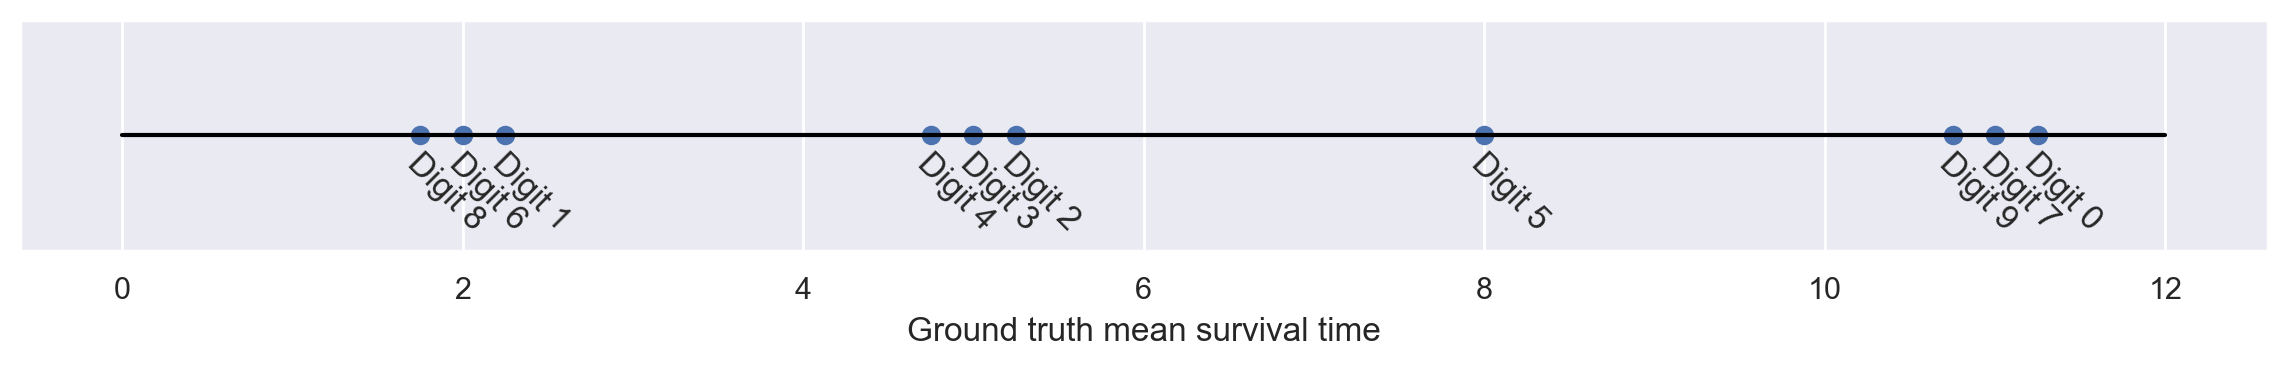

In [6]:
true_means = np.array([11.25, 2.25, 5.25, 5.0, 4.75, 8.0, 2.0, 11.0, 1.75, 10.75])
# plt.figure(figsize=(6, 1))  # for the paper, we used this without the digit annotation and manually added digit annotations afterward using software for diagramming
plt.figure(figsize=(14.5, 1.5))
plt.plot([0, 12], [0, 0], 'black')
plt.scatter(true_means, np.zeros(true_means.shape[0]))
plt.xlabel('Ground truth mean survival time')
for digit in range(10):
    plt.annotate('Digit %d' % digit, (true_means[digit] - .115, -.045), rotation=-45)
plt.yticks([])
# plt.savefig('survival-mnist-ground-truth-mean-survival-time.pdf', bbox_inches='tight')

### Ground truth censoring rates for different digits

Print entire test data's censoring rates across digits:

In [7]:
for digit, censoring_rate in [(digit,
                               1 - np.mean(np.concatenate(
                                   (label_direction[digit_direction == digit, 1],
                                    label_vis[digit_vis == digit, 1])))) for digit in range(10)]:
    print(digit, ':', censoring_rate)

0 : 1.0
1 : 0.0563876651982379
2 : 0.3798449612403101
3 : 0.35247524752475246
4 : 0.34419551934826886
5 : 0.7118834080717489
6 : 0.029227557411273475
7 : 0.9922178988326849
8 : 0.012320328542094416
9 : 0.9653121902874133


Print anchor direction estimation data's censoring rates across digits:

In [8]:
for digit, censoring_rate in [(digit, 1 - np.mean(label_direction[digit_direction == digit, 1])) for digit in range(10)]:
    print(digit, ':', censoring_rate)

0 : 1.0
1 : 0.052631578947368474
2 : 0.38732394366197187
3 : 0.3568773234200744
4 : 0.32377049180327866
5 : 0.6717171717171717
6 : 0.02092050209205021
7 : 0.9924242424242424
8 : 0.01976284584980237
9 : 0.9800796812749004


Print visualization data's censoring rates across digits:

In [9]:
for digit, censoring_rate in [(digit, 1 - np.mean(label_vis[digit_vis == digit, 1])) for digit in range(10)]:
    print(digit, ':', censoring_rate)

0 : 1.0
1 : 0.05753739930955126
2 : 0.37700534759358284
3 : 0.3508771929824561
4 : 0.3509485094850948
5 : 0.723342939481268
6 : 0.03198887343532686
7 : 0.9921465968586387
8 : 0.009708737864077666
9 : 0.9604221635883905


### Ground truth survival curves for different digits

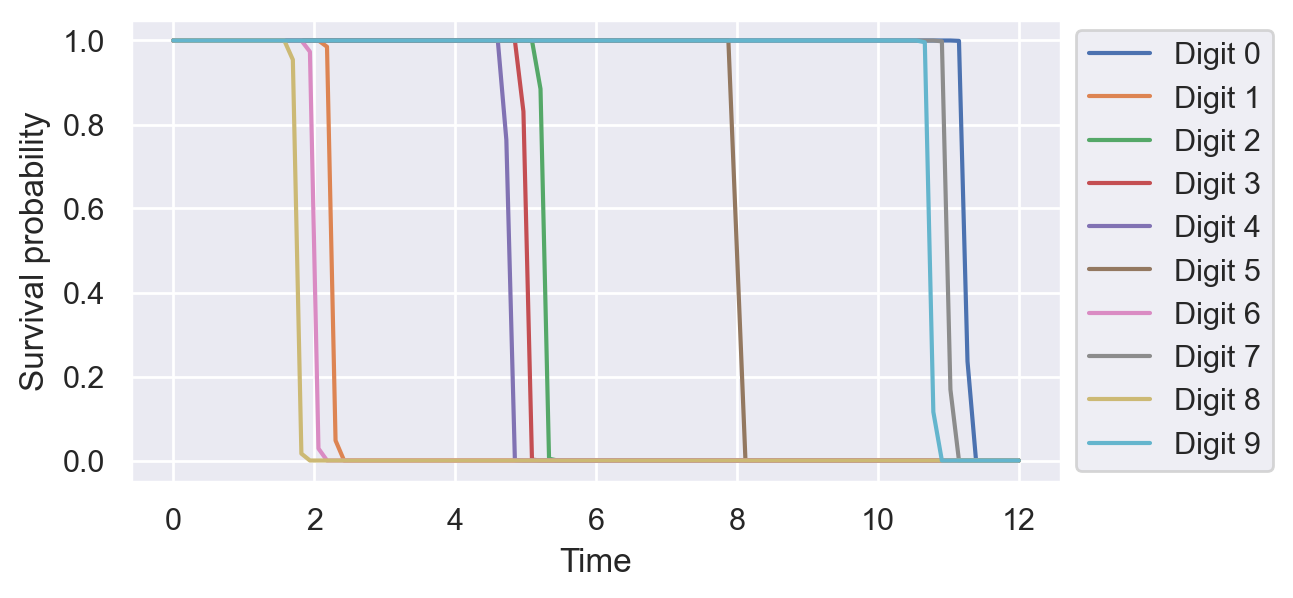

In [10]:
risk_scores_for_digits = [11.25, 2.25, 5.25, 5., 4.75, 8., 2., 11., 1.75, 10.75]

x = np.linspace(0, 12, 100)

plt.figure(figsize=(6, 3))

for digit in range(10):
    mu = risk_scores_for_digits[digit]
    v = 1e-3
    alpha = (mu ** 2) / v
    beta = mu / v
    y = scipy.stats.gamma.cdf(x, a=alpha, scale=1/beta)
    plt.plot(x, 1.0 - y, label='Digit %d' % digit)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.savefig('survival-mnist-ground-truth-survival-curves.pdf', bbox_inches='tight')

### Predicted survival curves for different digits¶

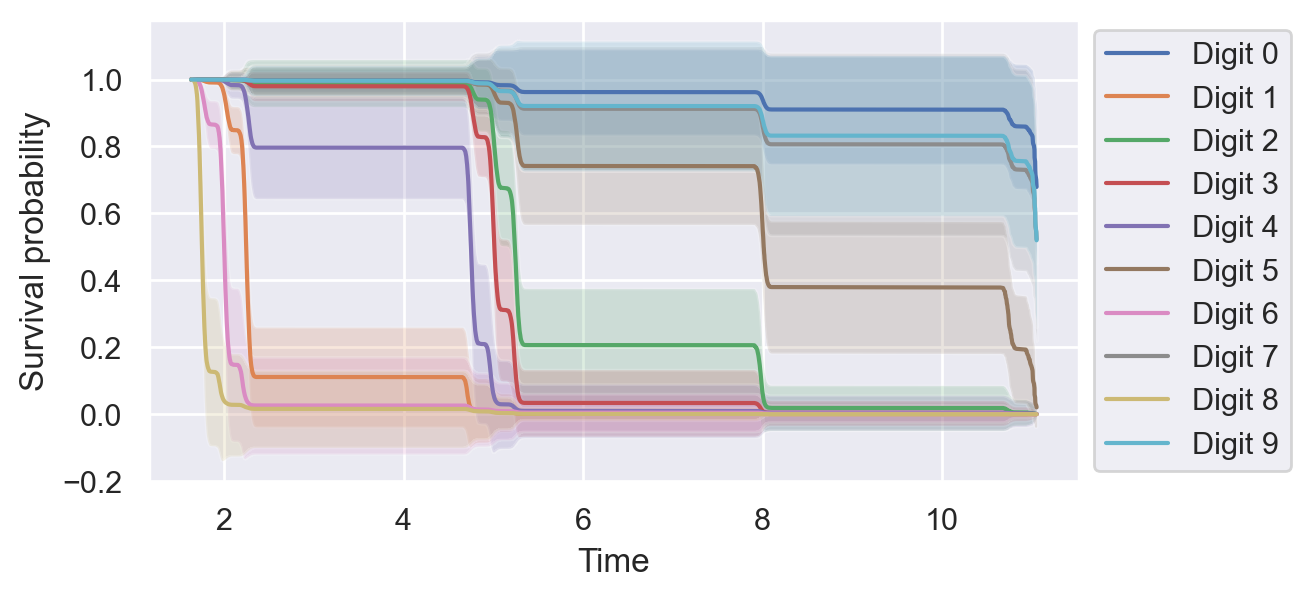

In [11]:
plt.figure(figsize=(6, 3))

for digit in range(10):
    mean_curve = predicted_surv_vis[digit_vis == digit].mean(axis=0)
    std_curve = predicted_surv_vis[digit_vis == digit].std(axis=0)
    plt.plot(unique_train_times,
             mean_curve,
             label='Digit %d' % digit)
    plt.fill_between(unique_train_times, mean_curve - std_curve, mean_curve + std_curve, alpha=.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Survival probability')
plt.savefig('survival-mnist-predicted-survival-curves.pdf', bbox_inches='tight')

### 2D PCA plot of the visualization data

In [12]:
median_surv_time_estimates = compute_median_survival_times(predicted_surv_vis, unique_train_times)

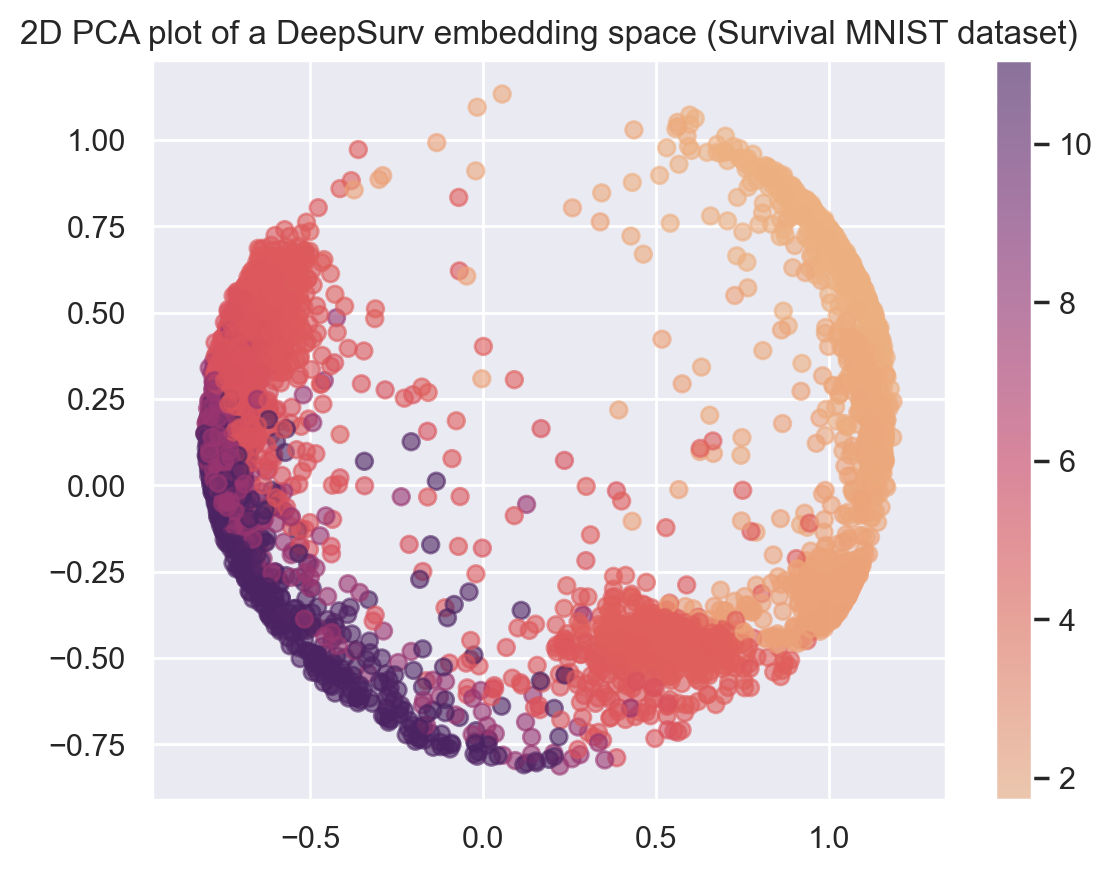

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_vis_pca_2d = pca.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_pca_2d[:, 0], emb_vis_pca_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D PCA plot of a DeepSurv embedding space (Survival MNIST dataset)')
plt.savefig('survival-mnist-embedding-space-pca-hypersphere.pdf', bbox_inches='tight')

### 2D t-SNE plot of the visualization data

/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/george/anaconda3_UDA/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


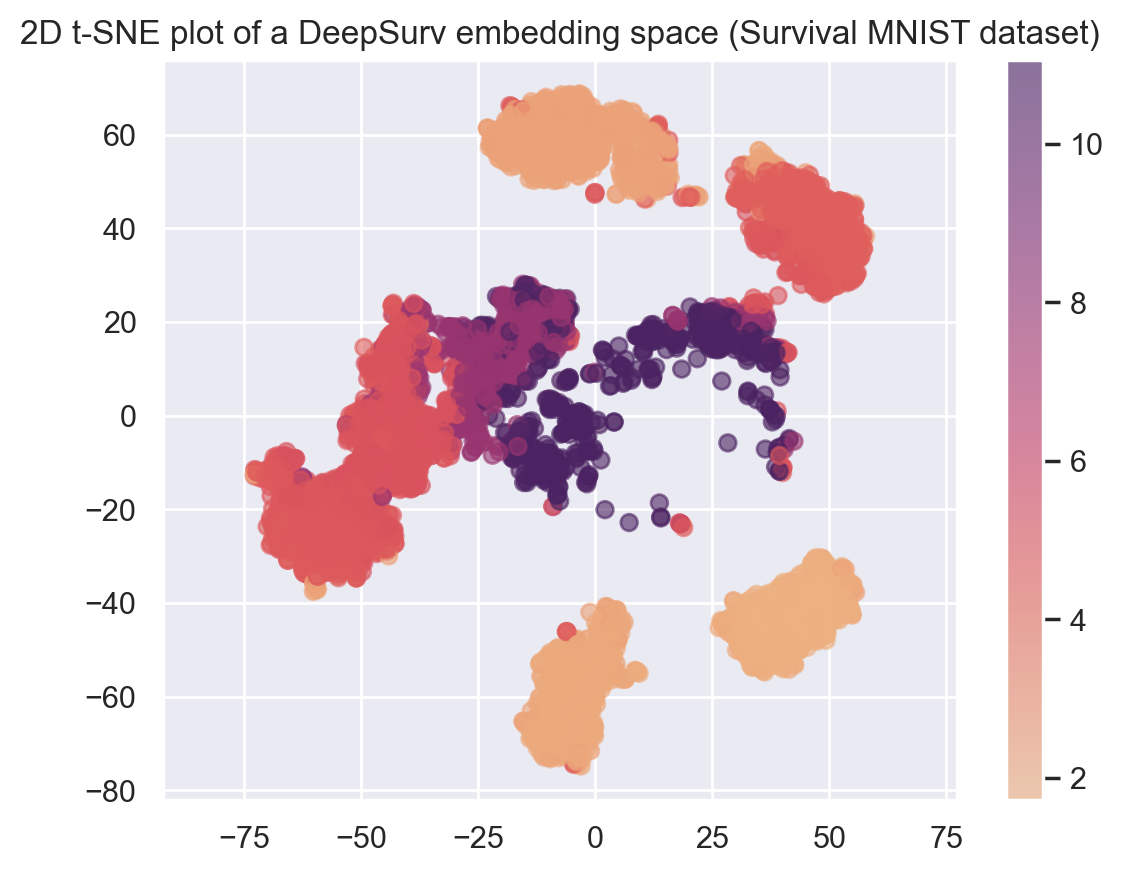

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=50, random_state=3676767249)
emb_vis_tsne_2d = tsne.fit_transform(emb_vis)
plt.axis('equal')
plt.scatter(emb_vis_tsne_2d[:, 0], emb_vis_tsne_2d[:, 1], alpha=.6, c=median_surv_time_estimates, cmap='flare')
plt.colorbar()
plt.title('2D t-SNE plot of a DeepSurv embedding space (Survival MNIST dataset)')
plt.savefig('survival-mnist-embedding-space-tsne-hypersphere.pdf', bbox_inches='tight')

### For different choices for the number of components, fit a mixture of von Mises-Fisher distributions

In [15]:
from lifelines.statistics import pairwise_logrank_test
import random
import torch

import models
import utils

seed = 1861600023

n_init = 100
n_clusters_to_try = list(range(2, 21))
logrank_p_values = []
cluster_assignments = []
cluster_models = []
samples = torch.tensor(emb_direction, dtype=torch.float32)
opts = {}
opts['max_iters'] = 100  # maximum number of EM iterations
opts['rll_tol'] = 1e-5  # tolerance of relative loglik improvement
for n_clusters in n_clusters_to_try:
    print('Trying %d clusters...' % n_clusters)

    best_ll = -np.inf
    best_cluster_assignment = None
    best_cluster_model = None
    for repeat_idx in range(n_init):
        random.seed(seed + repeat_idx)
        np.random.seed(seed + repeat_idx)
        torch.manual_seed(seed + repeat_idx)
        torch.cuda.manual_seed(seed + repeat_idx)
        torch.cuda.manual_seed_all(seed + repeat_idx)

        # create a model
        mix = models.MixvMF(x_dim=emb_direction.shape[1], order=n_clusters)

        # EM learning
        ll_old = -np.inf
        with torch.no_grad():

            for steps in range(opts['max_iters']):

                # E-step
                logalpha, mus, kappas = mix.get_params()
                logliks, logpcs = mix(samples)
                ll = logliks.sum()
                jll = logalpha.unsqueeze(0) + logpcs
                qz = jll.log_softmax(1).exp()

                # tolerance check
                if steps > 0:
                    rll = (ll-ll_old).abs() / (ll_old.abs()+utils.realmin)
                    if rll < opts['rll_tol']:
                        break

                ll_old = ll

                # M-step
                qzx = ( qz.unsqueeze(2) * samples.unsqueeze(1) ).sum(0)
                qzx_norms = utils.norm(qzx, dim=1)
                mus_new = qzx / qzx_norms
                Rs = qzx_norms[:,0] / (qz.sum(0) + utils.realmin)
                kappas_new = (mix.x_dim*Rs - Rs**3) / (1 - Rs**2 + 1e-6)
                alpha_new = qz.sum(0) / samples.shape[0]

                # assign new params
                mix.set_params(alpha_new, mus_new, kappas_new)

            logliks, logpcs = mix(samples)
            ll = logliks.sum()
            if ll > best_ll:
                best_ll = ll
                best_cluster_assignment = np.argmax(logpcs.numpy(), axis=1)
                best_cluster_model = mix

    result = pairwise_logrank_test(label_direction[:, 0],
                                   best_cluster_assignment,
                                   label_direction[:, 1])
    logrank_p_values.append(result.p_value)
    cluster_assignments.append(best_cluster_assignment)
    cluster_models.append(best_cluster_model)

Trying 2 clusters...
Trying 3 clusters...
Trying 4 clusters...
Trying 5 clusters...
Trying 6 clusters...
Trying 7 clusters...
Trying 8 clusters...
Trying 9 clusters...
Trying 10 clusters...
Trying 11 clusters...
Trying 12 clusters...
Trying 13 clusters...
Trying 14 clusters...
Trying 15 clusters...
Trying 16 clusters...
Trying 17 clusters...
Trying 18 clusters...
Trying 19 clusters...
Trying 20 clusters...


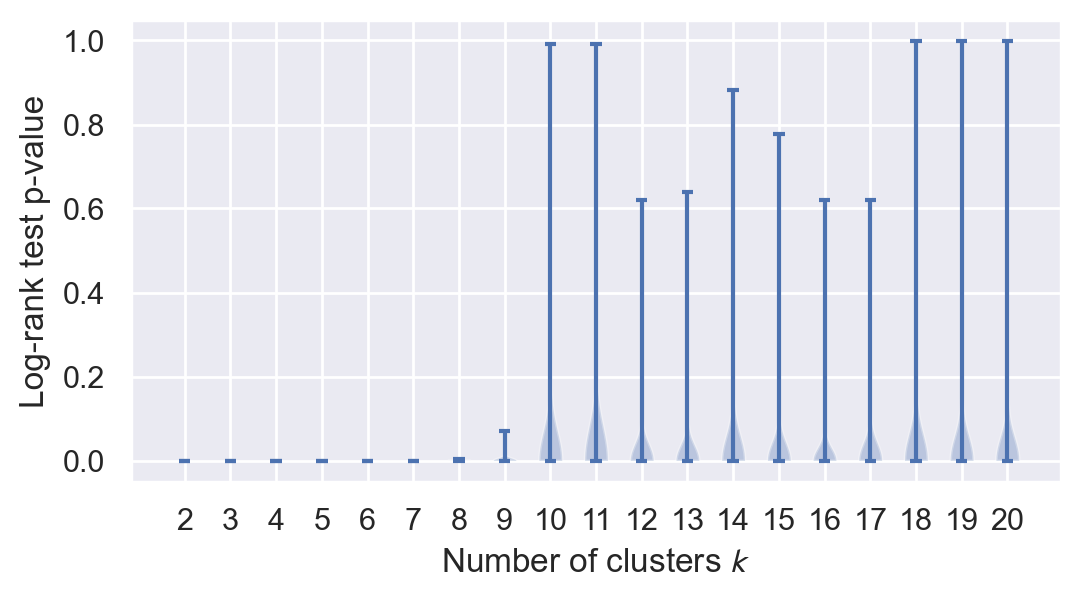

In [16]:
plt.figure(figsize=(6, 3))

# for a specific number of clusters k, sometimes the set of p-values for k consists of
# p-values that are all so close to 0 that the violin plot runs into numerical issues if
# we do not explicitly zero out the p-values
plt.violinplot([[(x if (x > 1e-6) else 0.0) for x in list_of_p_values]
                for list_of_p_values in logrank_p_values],
               n_clusters_to_try)
plt.xlabel('Number of clusters $k$')
plt.ylabel('Log-rank test p-value')
plt.xticks(range(2, 21))
plt.savefig('survival-mnist-avg-pairwise-logrank-pvalue-vs-nclusters-hypersphere.pdf', bbox_inches='tight')

### Using different clusters' anchor directions, make random raw input vs projection value visualizations

In [17]:
# these are the anchor directions defined by each digit as a concept using anchor direction estimation data
# (this will serve as "ground truth" for what directions the digits should actually point in whereas the
# neural net was never trained to know what the digits explicitly are)
digit_anchor_directions = np.array([emb_direction[digit_direction == digit].mean(axis=0) - center_of_mass
                                    for digit in range(10)])
digit_anchor_directions_normalized = l2_normalize_rows(digit_anchor_directions)

0 : [3864 6104 5971 7481 6133 1733 2607 4037 1352  532]
1 : [7282  465 3219 1189  472 2704 6452 3568 3873 2857]
2 : [5317 2328 3937 5868 2804 1823 5749 1337 7035 7093]
3 : [5566 1831 5850 2931  329 4153 7032 7341 1899 4900]
4 : [3290 5976 5027 3314   86 7443 1004 7407 4471 4409]
5 : [4004 6027    8 4216  256 2541 6789 5297 6003 6335]
6 : [3160 4400  831  650 3722 3375 4853 4152 6431 6502]
7 : [1359 2477 7371 5407 4596 6030 3275 1679 1756 1015]
8 : [6249  803 2441 2900 7031   23 7435 5017  388 4649]
9 : [2200 3508 3915 6147 4072 1170 2635 2484 3542 2904]
10 : [1573 6812 1898 4024 1241 6180 4067 1082 2117 3075]


/tmp/ipykernel_4001613/3478131287.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


0 : [  82 6369 7215 2095 2589  319 5313 4691 1948 5148]
1 : [5042 5976 3239 6286 7185 1690 4246 3905 3535 2681]
2 : [3710 1369 5140 4008 1702 6372 2077 4961 7143 3730]
3 : [2360 2002 3502 5881 2781 3273 3358 1924 6390 6639]
4 : [2657  347 5811 4382 5562 6265 3506 2897 4065 2881]
5 : [3770 6319 7220 7443 7160 6049 4520 3578 4888 3691]
6 : [ 437 6996 5815 6370 4151 6955 4849 3855  412 6644]
7 : [ 554 5504 4909 3449 7452 7453  731 1856 6099 5273]
8 : [6596 4484 5859 3374  564 2388 5785  863 1812 7464]
9 : [7489 5514 3508 5009 4326 2827 5571 2243   29 1297]
10 : [ 880 1857 2281 5406 1587 7142  780 2913 3877 3079]
0 : [4208 1070  241 4474 5106 2074  185 2321 7100 3687]
1 : [2184 3607 7056  372 5603 2659 1431  745 1459 1806]
2 : [4703 4240 4671 4433 6043 6485 6403 2835 6945  435]
3 : [ 268 1038 3852 6180  148 4377 1739 4086 3601 4803]
4 : [1988 3633  758 6704 6396 1419 5754 2573 3827 1591]
5 : [5209  248 6683  179 1645  531 5716  273 1628 5746]
6 : [ 264 2990 1343 2603 7120  100 2304 7306 27

/tmp/ipykernel_4001613/3478131287.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


0 : [2832 4428 2338 4844 5008 6683 3459 2142 3814 2529]
1 : [7171 1468 2941 2662 2209 1954 5339 4859 2856 1146]
2 : [6476 4816 6768 1414 5560 2211 6454  240 3118 6004]
3 : [6632 3120 3926 7285 3264 5471 5439 1312 2539 1701]
4 : [2256 6933    6 1870  140 4246 2154 3159  586 1747]
5 : [3117 5343 4216  150 5943 6516 6003 2500  733  897]
6 : [6401 7198 6218 1621 4287 2255 6565 3555  136 6406]
7 : [4259 4017 3004 1029  184 6548 7411 3129 6761 4371]
8 : [3645 7204 6249 7030 1304 2380 7431  962 1196 7370]
9 : [ 224 1627 2265 2590 1617 5664 6066 5153 2037 3095]
10 : [1896 4169 4702 5530 2883 6908 7190 1175 6168 2030]


/tmp/ipykernel_4001613/3478131287.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


0 : [2947 7371 3711  310 3428  708 4537 1052   61 2385]
1 : [6633 1513 1568 1631 7040 2965 1297  379 6413 1466]
2 : [2630 2086 1477 4796 1287 5880 2478  429 2235 4134]
3 : [2204 3126 4077  592 3143 1970 5421 2227 1991 7097]
4 : [4629 2115 3294  603 4157 5494 3654 4230 7287 7229]
5 : [4938 5082  430 3150 4011 1729 5278 3061   37  746]
6 : [3979 4694 3816 5467 5752 4917 5605 2051 3970 2257]
7 : [5744 3296 2387 2806 7328 4146 3490 3578 7160 5490]
8 : [2735 1940 2935 6980 5483 5934 2330 6846 1848 2993]
9 : [5749 6111 4366 4313 6125 1556 2405 5069 1823 5782]
10 : [1664 3941 5633 7440 5906  280 7052 3799  851 5282]
0 : [3409  125 3315 3712 5437 3247 4059 4338 7192 7406]
1 : [2183 3643 6443 1273   25 3721 6752 4264  661 1822]
2 : [6334 1226 1834  295 5435 2291 5648 4744 2144 1421]
3 : [6953 4945 2888 4621 5196 2671 6327  767 6231 2019]
4 : [3826 6817 3704  398 1114 5369 2658 1841 5173 6154]
5 : [3345 2230 3754 3304  251 1617 7285    5 3888 6397]
6 : [2002  339 2628 1645 4700 6157 1328 1034 26

/tmp/ipykernel_4001613/3478131287.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


0 : [4623  362 4840  179  418 5373 7053  960 3651 4501]
1 : [ 852 5393 4276 6242 4313  840 2939 1943 3859 5390]
2 : [ 832  991 3146 2238 2760 3367 2751 4475 5787 6075]
3 : [7249 4111 7276 4022  534 6670 5697 1445 4900 5946]
4 : [4368 3732 5665 4288 4246  634 1682 6445 6716 6367]
5 : [6987 1820  356 1811 3334 4622 3783 6155 5814 3939]
6 : [1303 2666 1392 5266  677 1926 6761 1873 4904 4454]
7 : [4892 2562 5305 6270 4692 2177 5013  651 1459 7485]
8 : [6811 6239 7463 1645  395 1874 4866  517 6211 7370]
9 : [3085 3546 7350 4382  389 3319 1869 2395  660 1552]
10 : [5896 2049 5289 6057 2645 4837 1381 3374 6093 1032]


/tmp/ipykernel_4001613/3478131287.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


0 : [3409  125 3315 3711 5437 3247 4056 4338 5291 7321]
1 : [2183 3643 6431 1273   25 3721 6752 4264  661 1822]
2 : [6334 1226 1834  295 5435 2291 5648 4744 2144 1421]
3 : [6953 4945 2888 4621 5196 2671 6327  767 6231 2019]
4 : [7045 1249 6817 5116 1820 6889  398 3871 3522 3704]
5 : [1617    5 4368  251 3358 7443 3304 2230 4065 5003]
6 : [ 794 1645 4012  511 1552 3195   89 1328  339 4019]
7 : [3983 5751 2258 2539 1429 5059 5763  750 6670 7242]
8 : [ 772 1543 5261   86 6167 1282 1233 1143 5452 6956]
9 : [ 443 1050 4146 4128 1969 7351 4033 3693 6858 2425]
10 : [1602  884 4993 2819 6657 4307 6776 3366 1614 5414]
0 : [3858    8 5337 2155 7463 5924 4273  507  171 3842]
1 : [1168 2805 6404 5687 4639 3997 4437  551 6239 1913]
2 : [3694 6020 5915 2812 2515 3551 5582 2284 2521 6526]
3 : [1704 3129 6775 4076 3250 6389 2117 2669 4552  326]
4 : [1476 1882 2165 4559 4042  940 4752 6503 1834 6272]
5 : [2573  313 3548 1085 3484 7087 6166 2144 4064 1992]
6 : [5767 2364 2564 5886 4292 1933 5442  996 49

/tmp/ipykernel_4001613/3478131287.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,


0 : [2209 1474 7247  291 5730 5679 4359  605 1867  981]
1 : [1320 3175 5122 5222 6295 4733 2817 6849 3481 4918]
2 : [5585 2110 6616 5205 2367 5807 5599 5999 7066 4321]
3 : [4970 2293 4203 3664 2755 5714 3002 6157 3223 6490]
4 : [2407  751 4262 6680  539 7187 3095 3358 1591 7207]
5 : [7160 1495 4673 6663  760 1588 6578 5530 7285 2597]
6 : [3767 5002 2622 4841 2801 1574 4113 3137 3489 6229]
7 : [1239 4157 2264 3592 6717 4043 5014 3650 2596 5661]
8 : [5825 6405 2533 2542 5754 1219 4693 3739  904 5250]
9 : [4702 4379 6433 7176 6516 7290 1058 6325 2594 5915]
10 : [6963 4677  376 4996 7031 5793  167 3370  836 1379]
0 : [ 654 3093 2740 4297 4120 6362 6473 6801 2475 1888]
1 : [6204 2412  948 5223  234 1137 6819 6208 3639 2585]
2 : [2780 1177 4344 1537 2843 3677 4657 5930 3237 2889]
3 : [5238 3468 4263 3172 7102 7380 3735 5606 3080 2546]
4 : [7121 6964 5881 7205  841 4493 6073 6984 6753 6676]
5 : [3767 7446 6100 4253 2470 4485 2466 3537 3255  374]
6 : [6384 6655 6029 1590 1815  566 3956 7494 54

/tmp/ipykernel_4001613/3478131287.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


0 : [3409  125 3315 3711 5437 3247 4056 4338 5291 7321]
1 : [2183 3643 6431 1273   25 3721 6752 4264  661 1822]
2 : [6334 1226 1834  295 5435 2291 5648 4744 2144 1421]
3 : [6953 4945 2888 4621 5196 2671 6327  767 6231 2019]
4 : [7045 1249 6817 5116 1820 6889  398 3871 3522 3704]
5 : [1617    5 4368  251 3358 7443 3304 2230 4065 5003]
6 : [ 794 1645 4012  511 1552 3195   89 1328  339 4019]
7 : [3983 5751 2258 2539 1429 5059 5763  750 6670 7242]
8 : [ 772 1543 5261   86 6167 1282 1233 1143 5452 6956]
9 : [ 443 1050 4146 4128 1969 7351 4033 3693 6858 2425]
10 : [1602  884 4993 2819 6657 4307 6776 3366 1614 5414]


/tmp/ipykernel_4001613/3478131287.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


0 : [6761 3342  639 4338 1929 1105 1857 5083 4896  638]
1 : [7010 5311  856  433 3438 4874 7245 4815  645  874]
2 : [5005  270 3780 2918 3129 3601 3176 3323  774 1318]
3 : [1970 4406 5369 5074 1794  941 2649 4664 4566 1991]
4 : [5090 4762 6486 2232 4838 4024 3895 2036 6496 5956]
5 : [3772 5625 3523  788 5299 7287 6788  437 2203  124]
6 : [2059 1024 4753 3522 4069  283 3580 3491 5879 6619]
7 : [2564 3397 1617 6487 3107 5101 5598  274 2770 5832]
8 : [5773 1608 3109 4008 7240 5807 6772 2818 7156 4101]
9 : [6434 3035 4582 5782 4674 1256 1521 4918 6547 2317]
10 : [1694 2504 7042 2445 5137 2290 4383 2751 6801 4959]
0 : [6058 1800  472 4816 3638 1660 5541 2636 6278 6203]
1 : [2358  876 1340 1597 3912 4454 5731 1762 6764 5746]
2 : [4533 2114 6634 4390 4942 7439 3483 2124 5752  749]
3 : [3313 7123 2836 5881 4753 5850 7299 4986 3064   64]
4 : [6918  751 1591 3373 5631 6620 4686  517 1646 4365]
5 : [1423  760 2054 3395  842  510 7069  919 6817 7443]
6 : [6307   49 5002  902 3840 3770 2019 4441 22

/tmp/ipykernel_4001613/3478131287.py:172: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


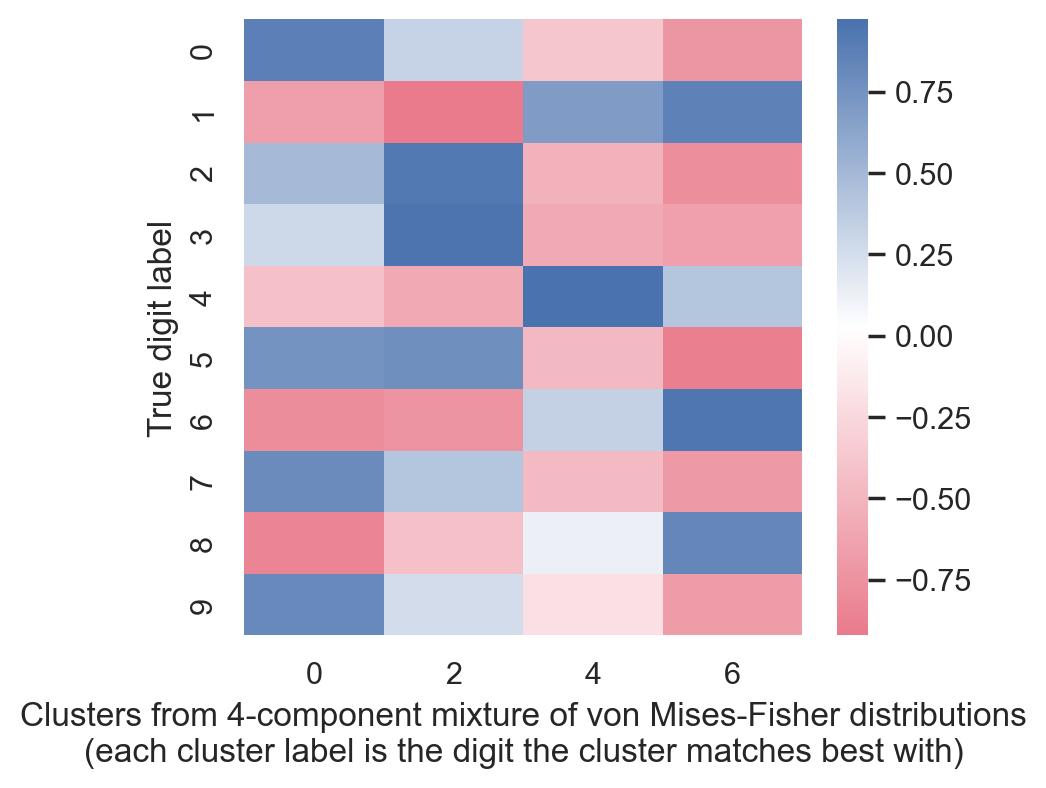

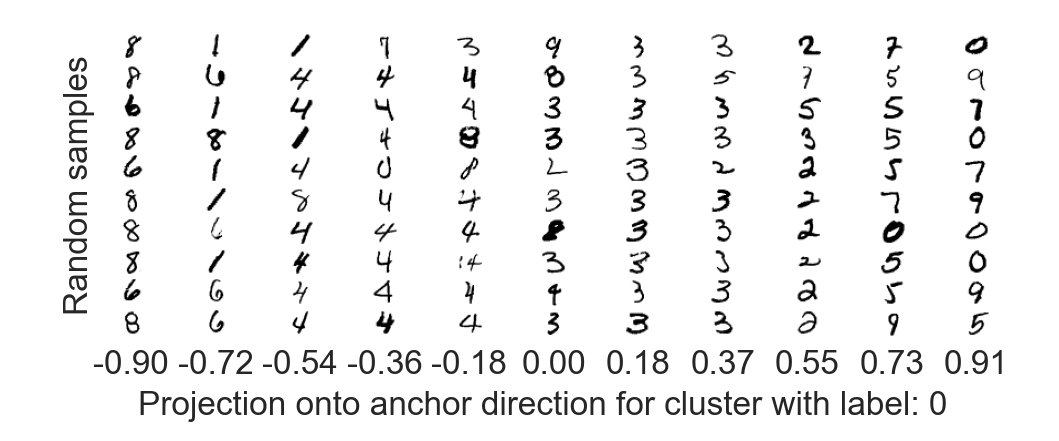

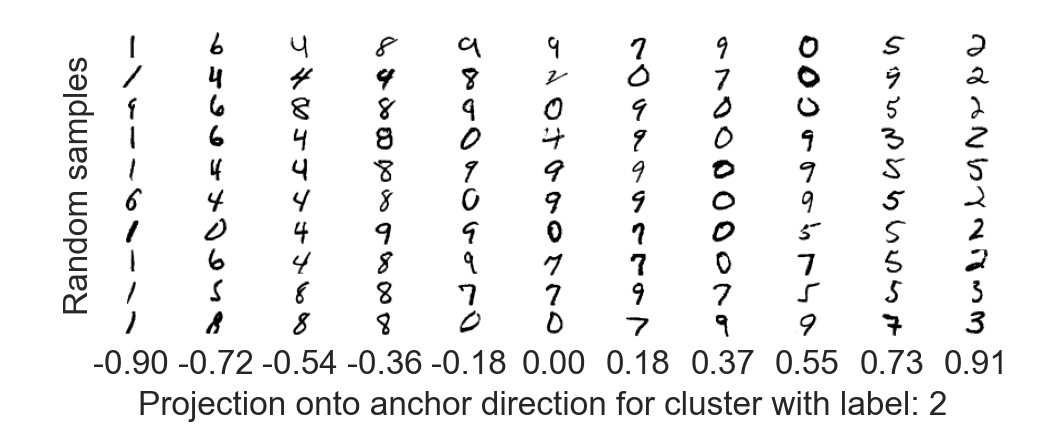

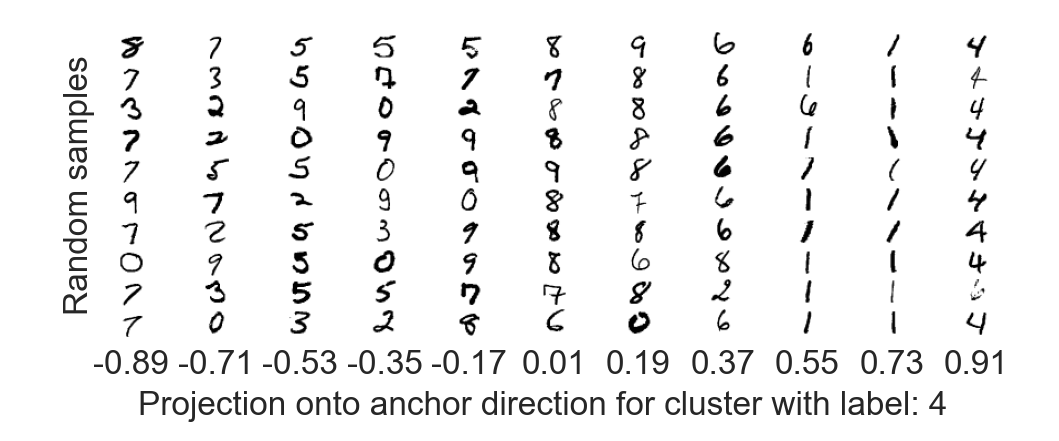

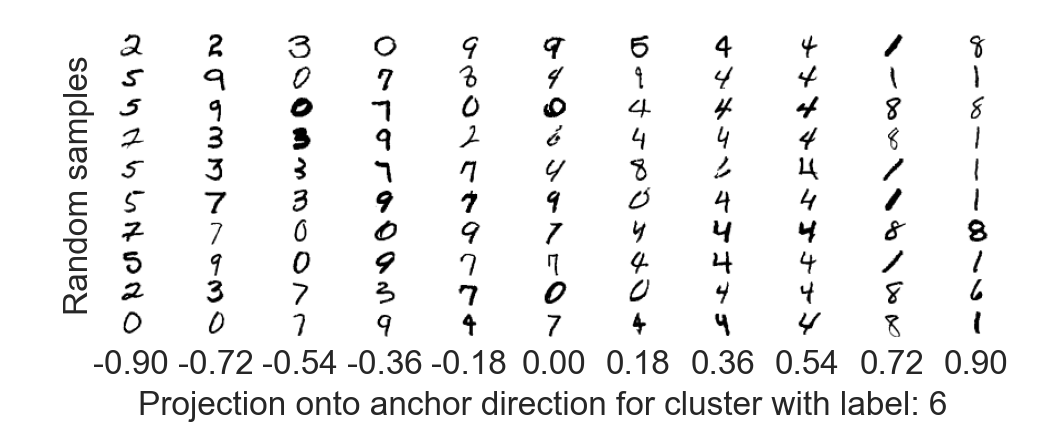

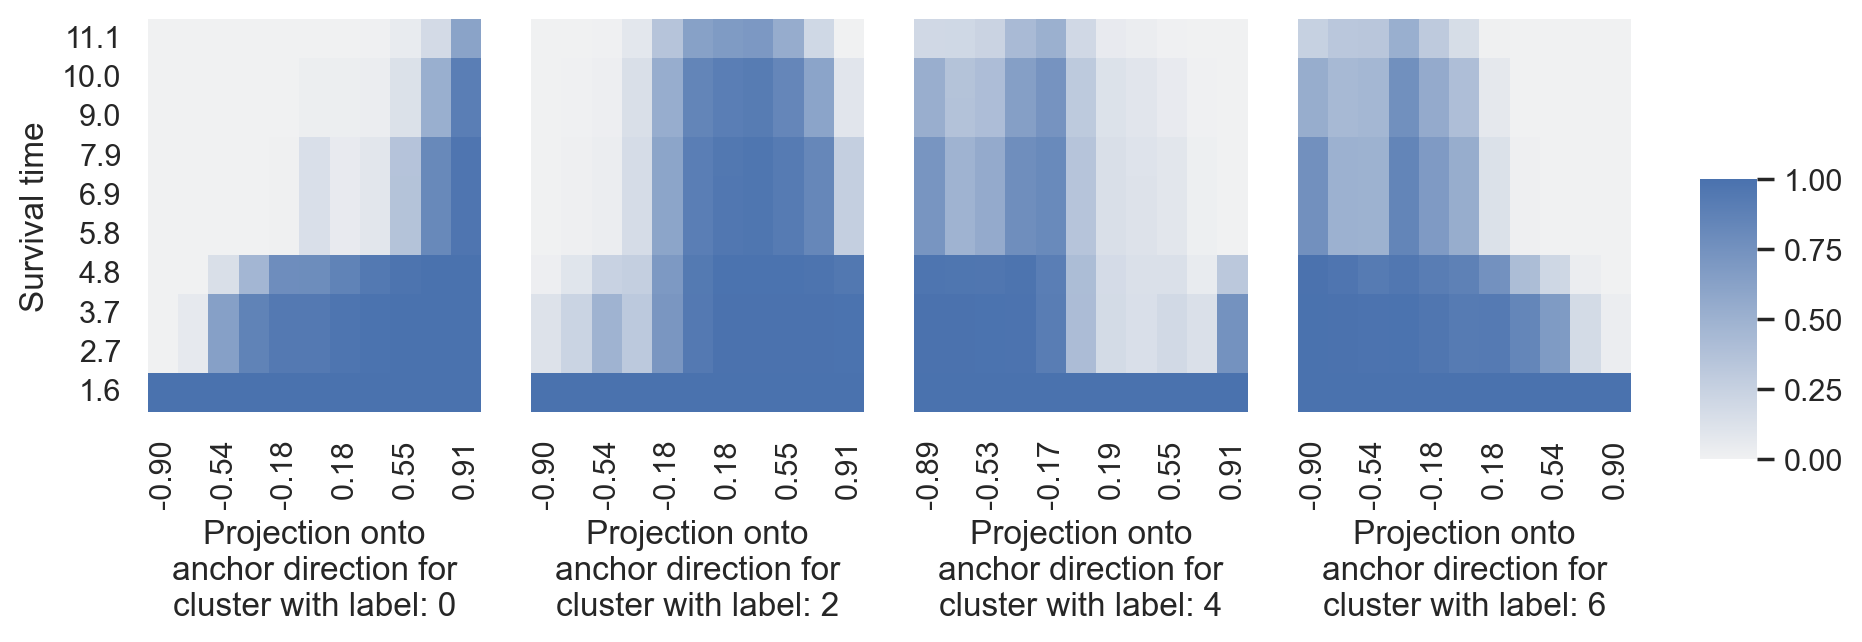

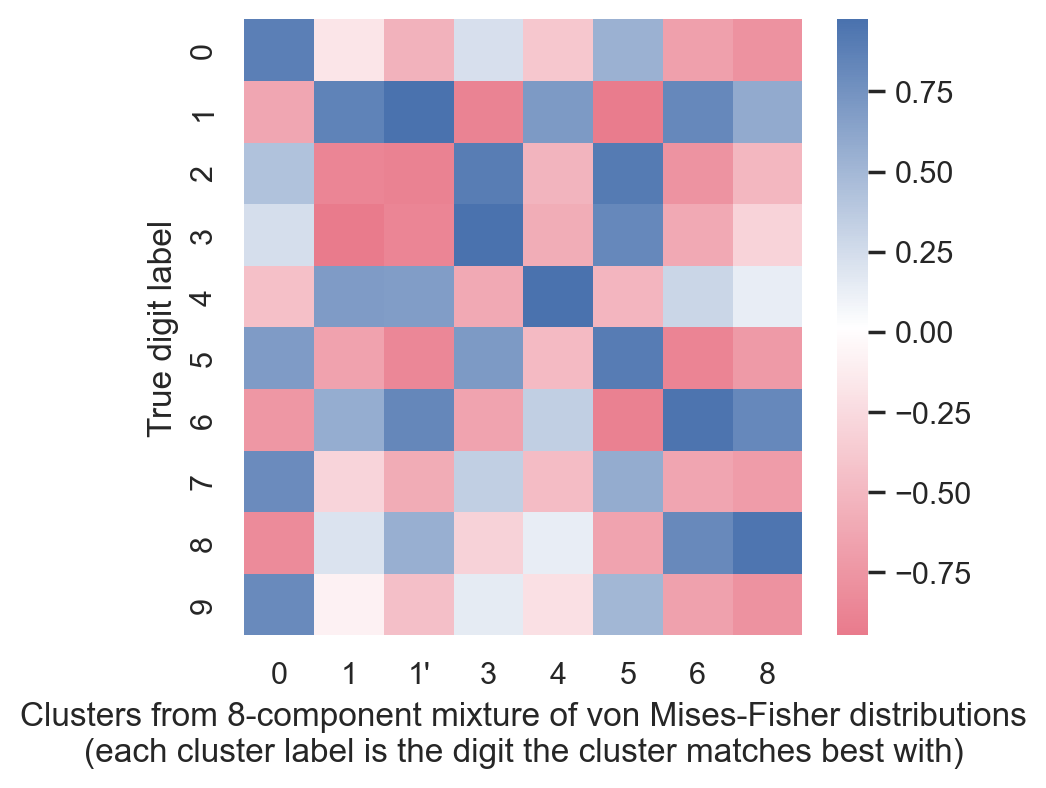

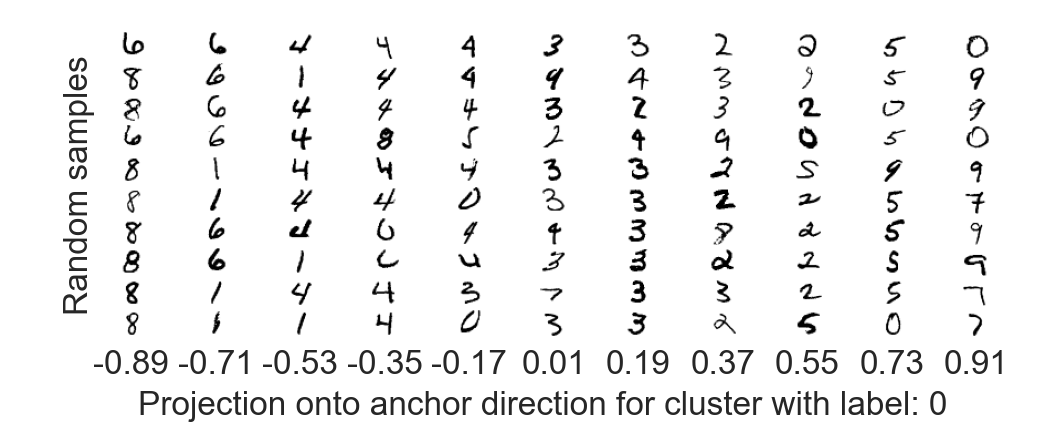

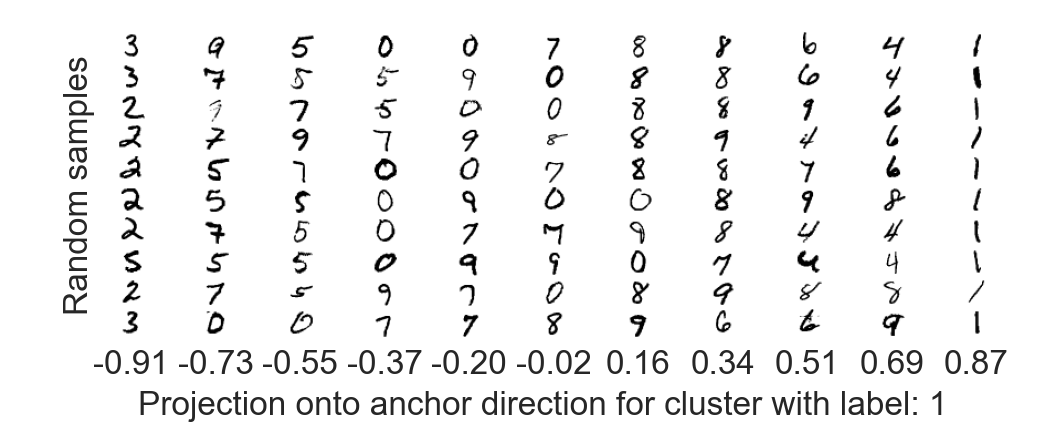

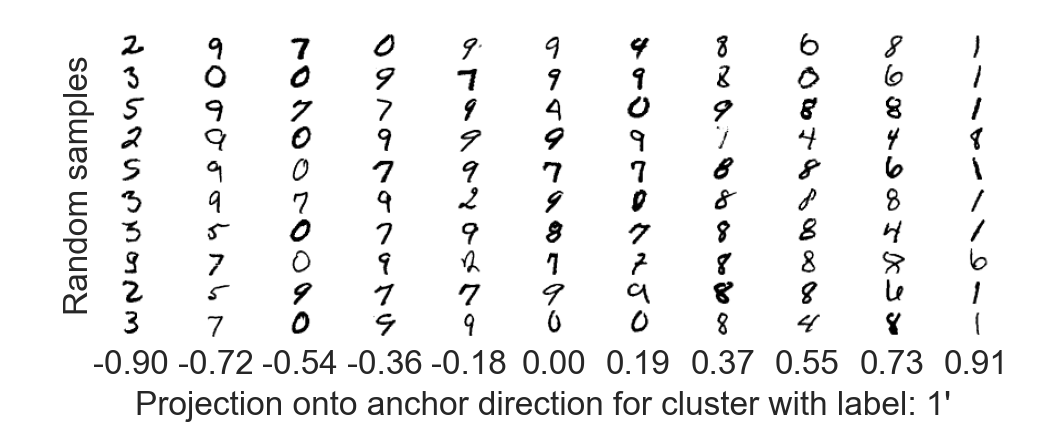

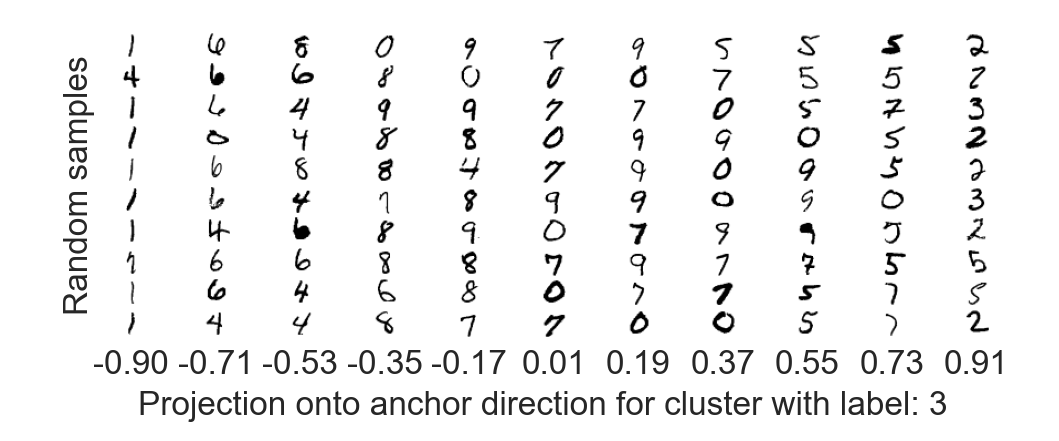

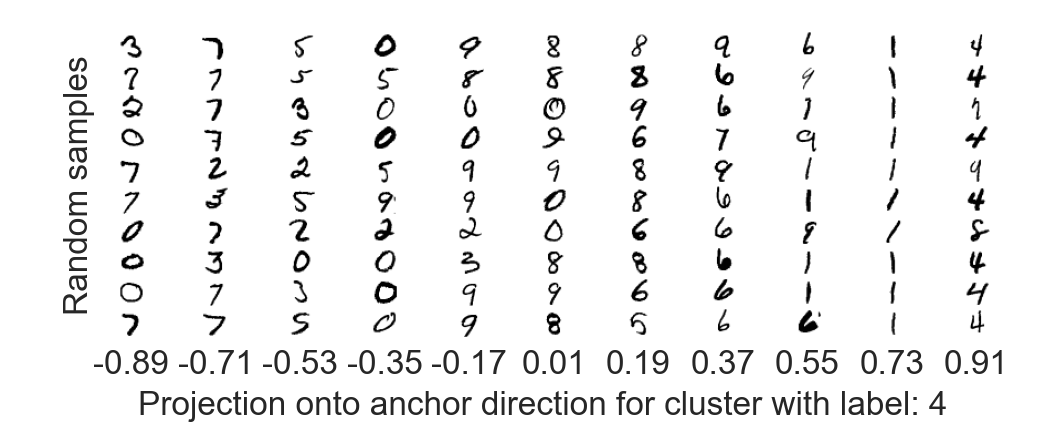

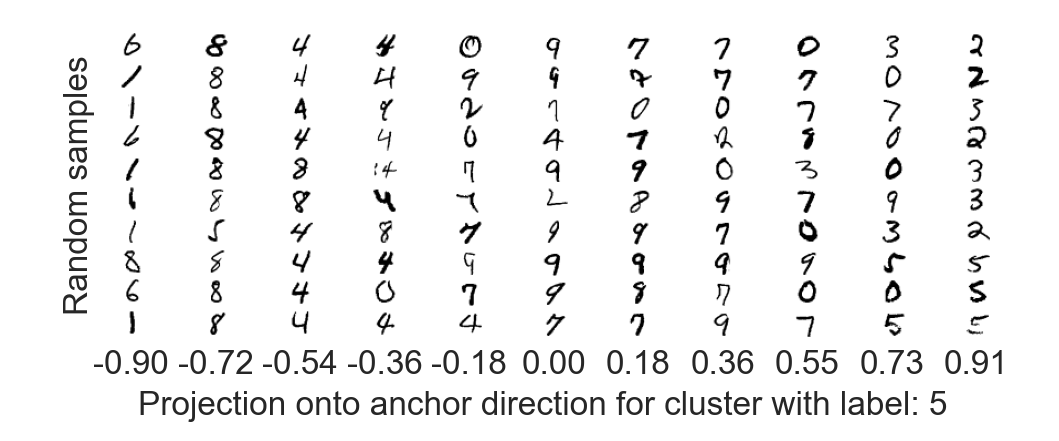

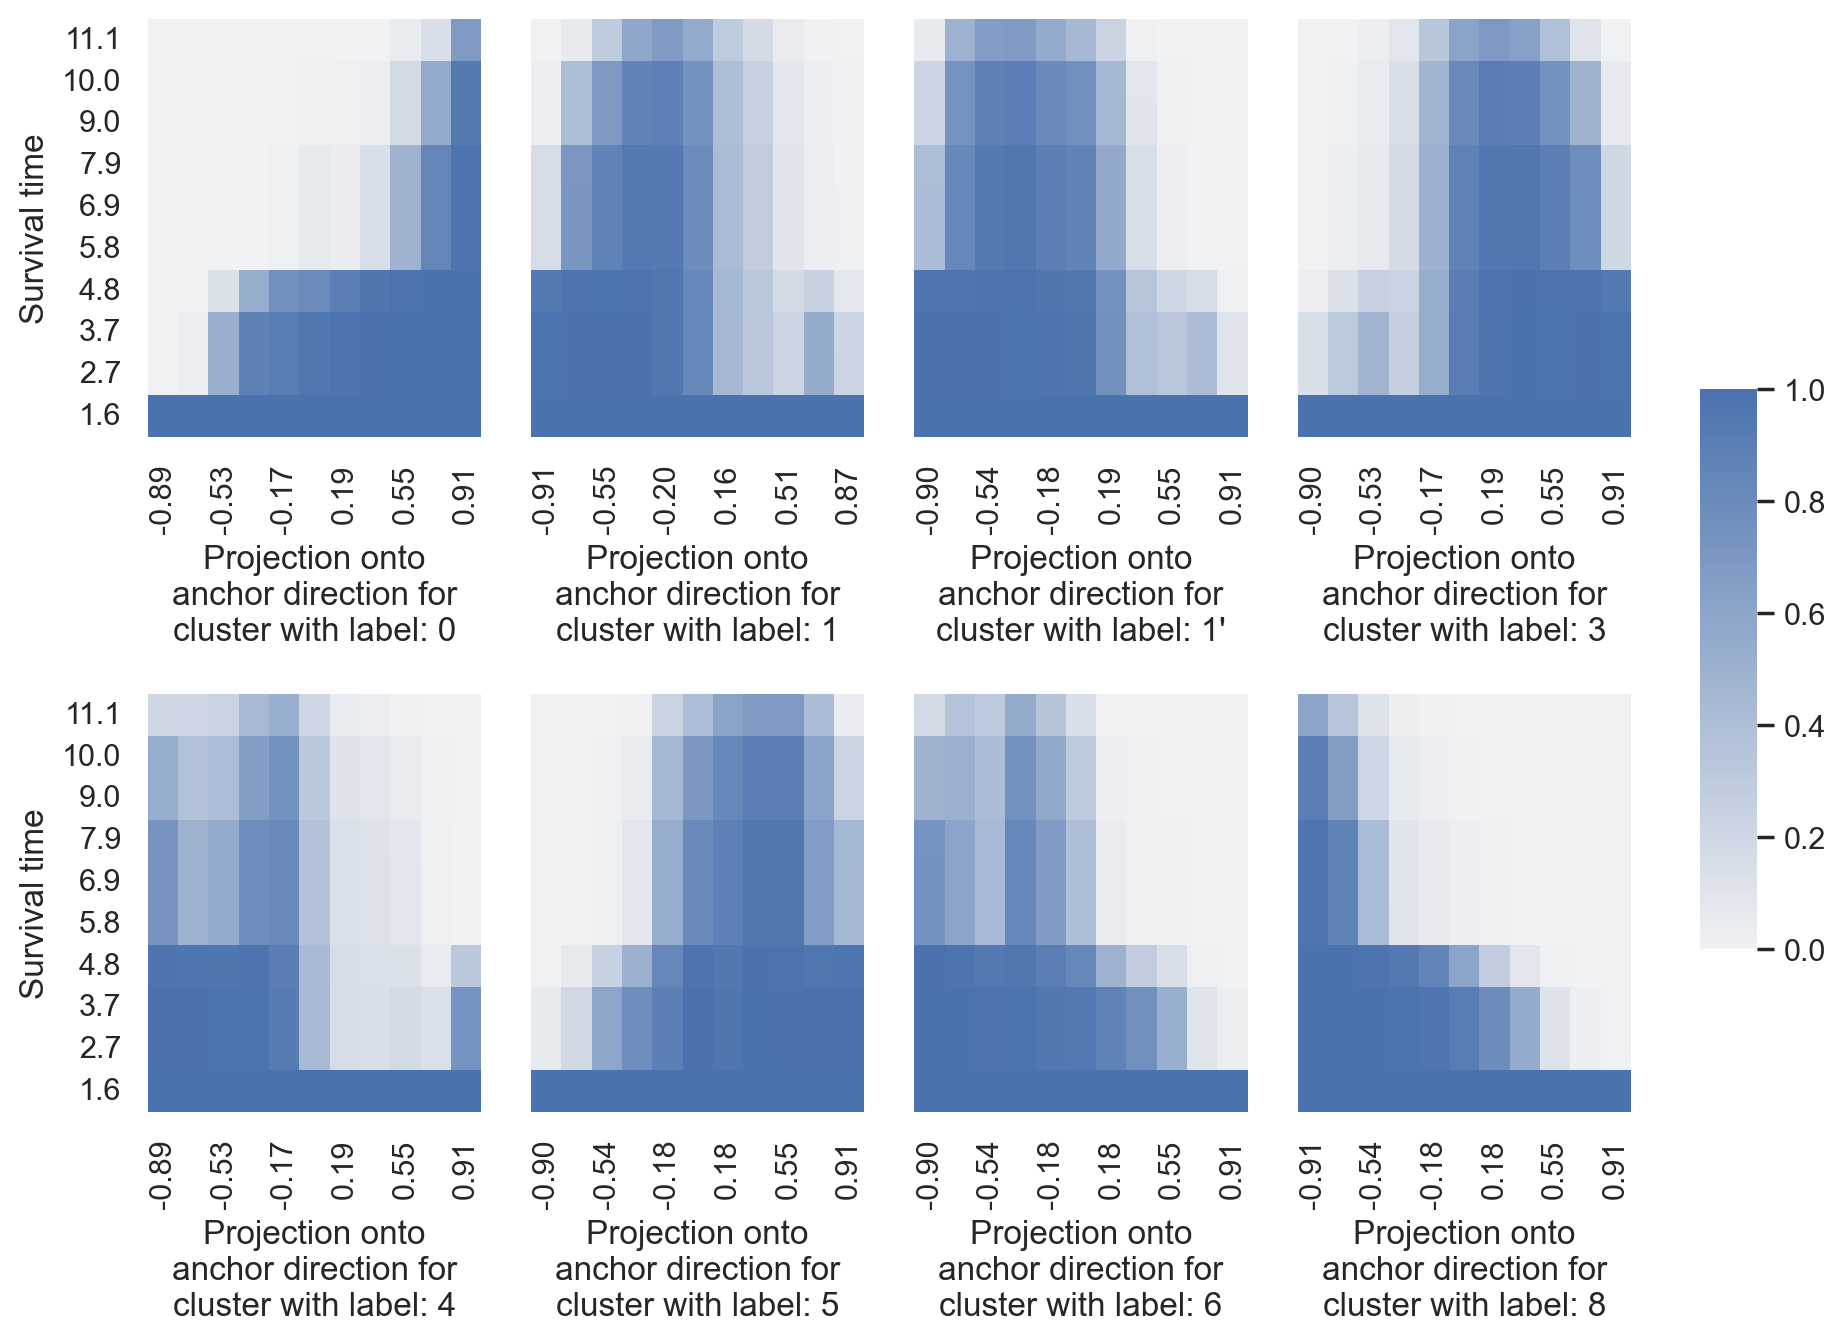

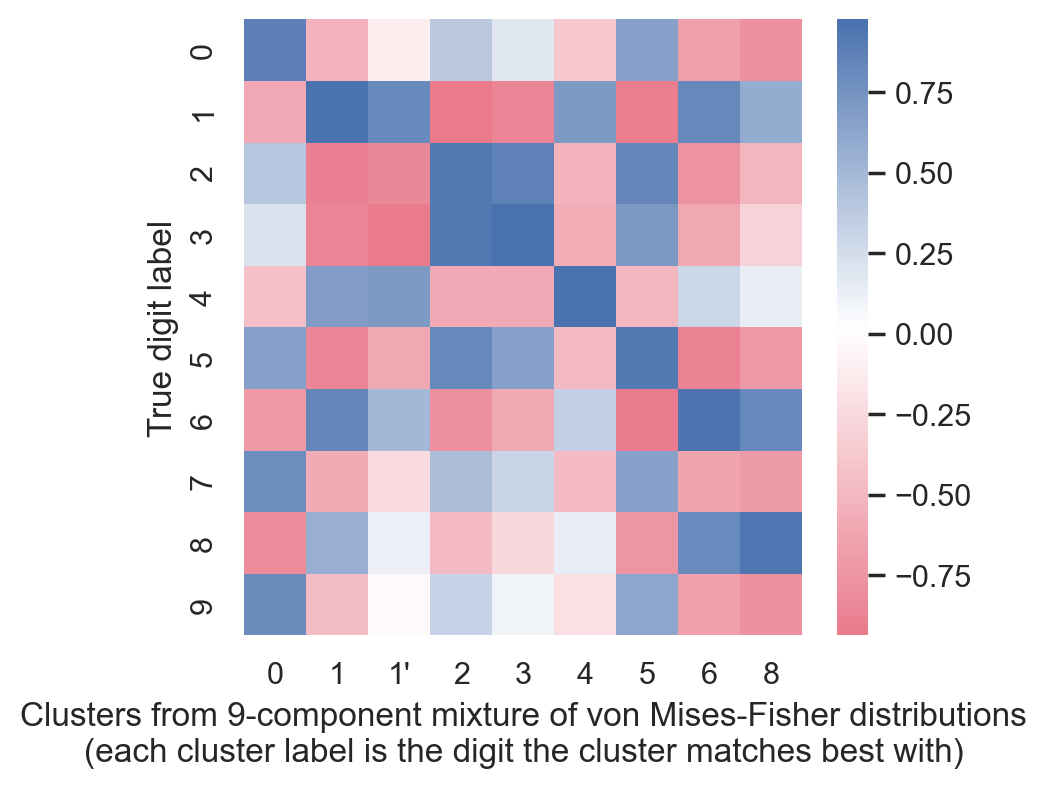

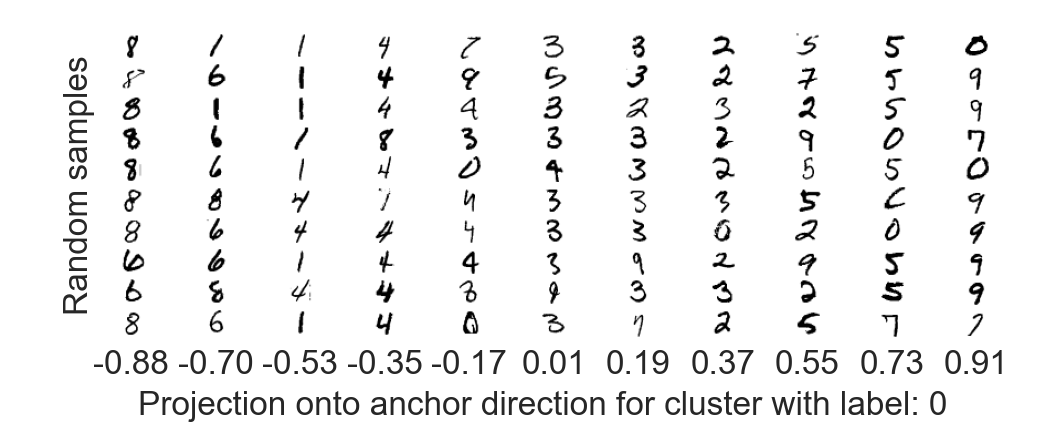

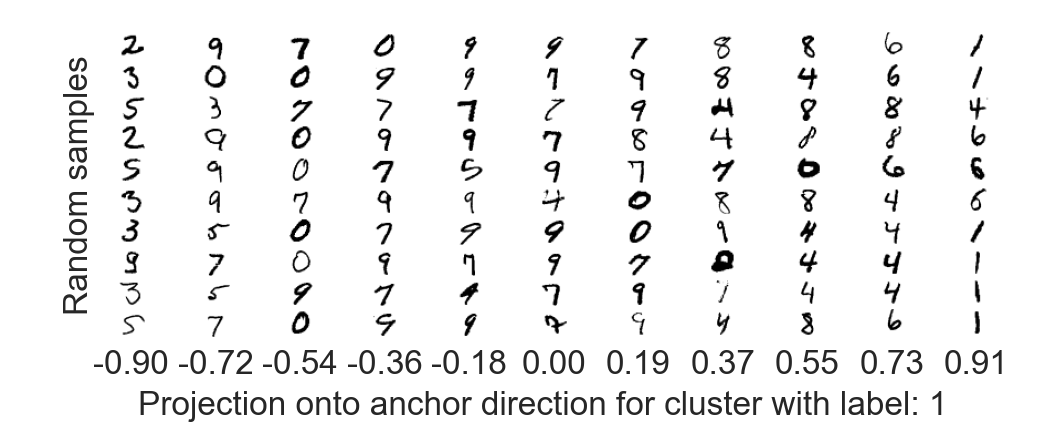

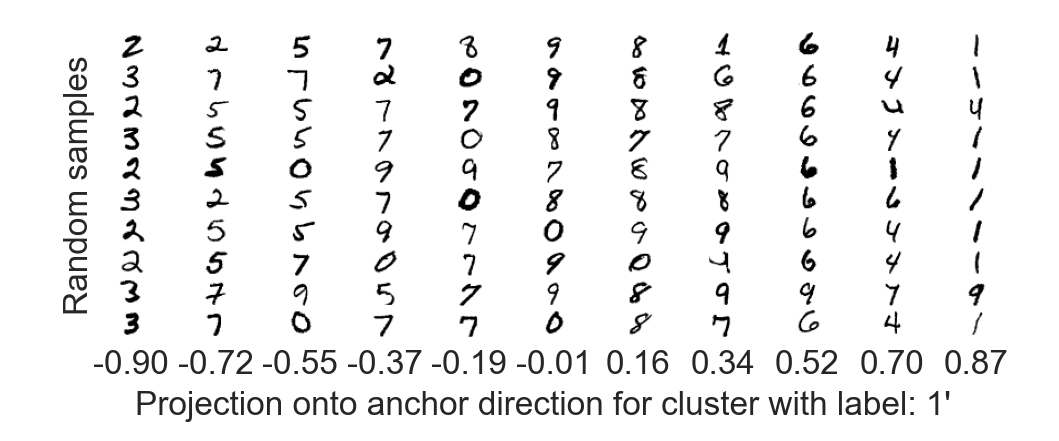

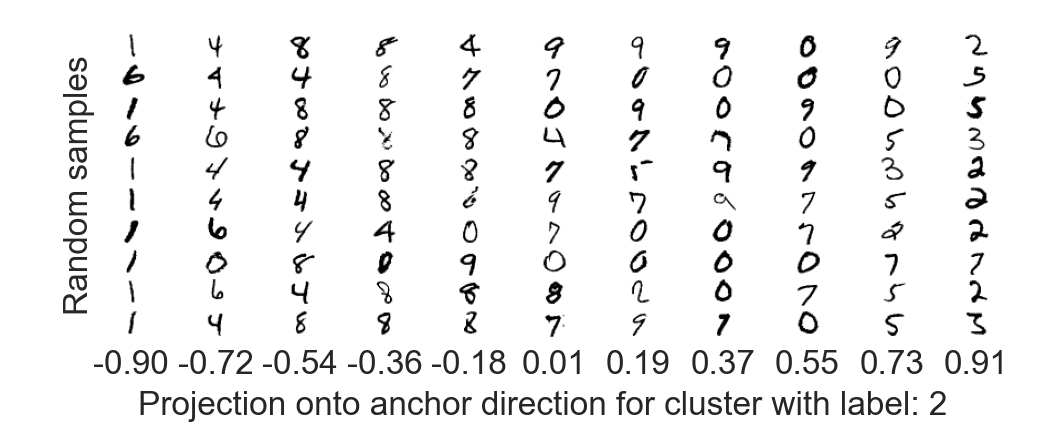

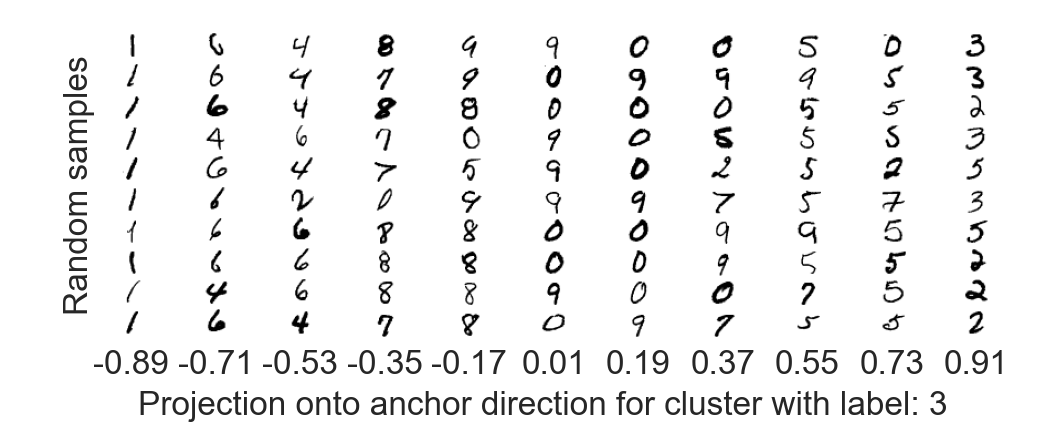

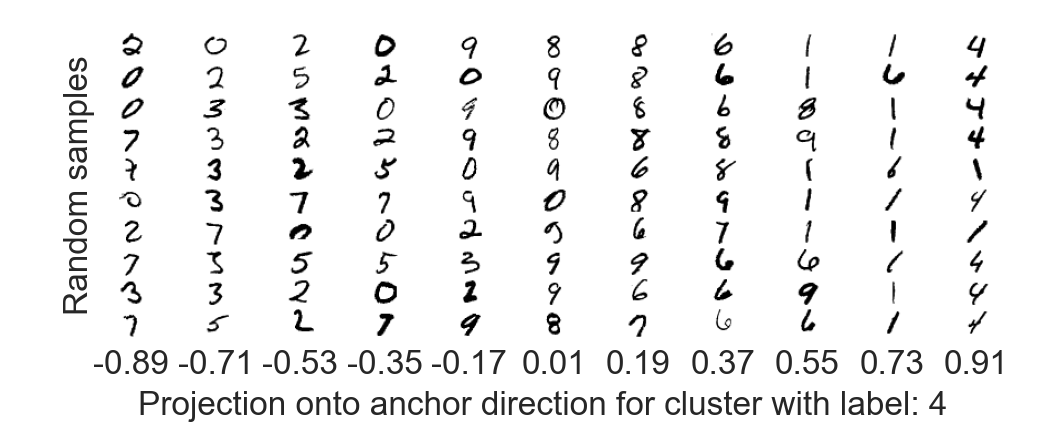

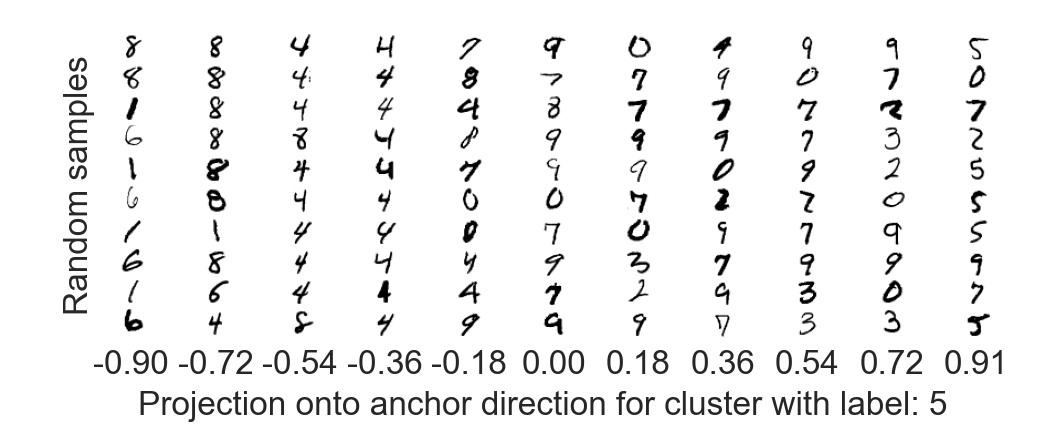

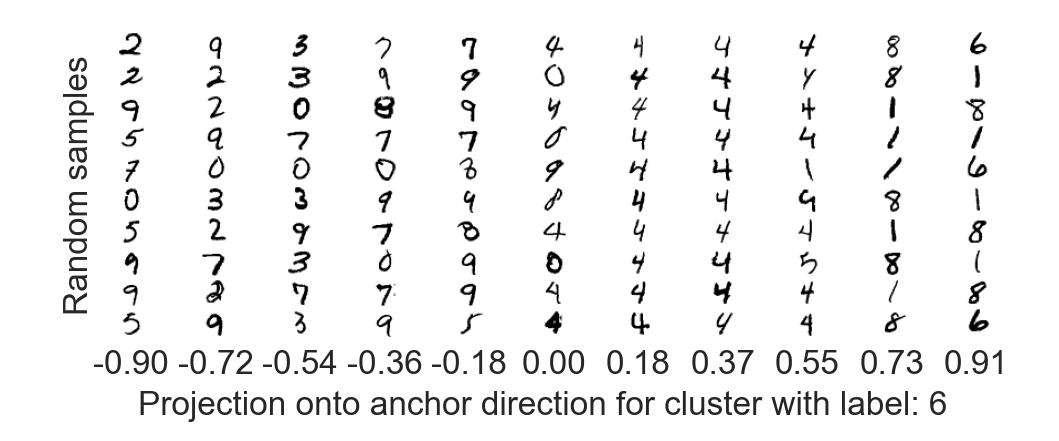

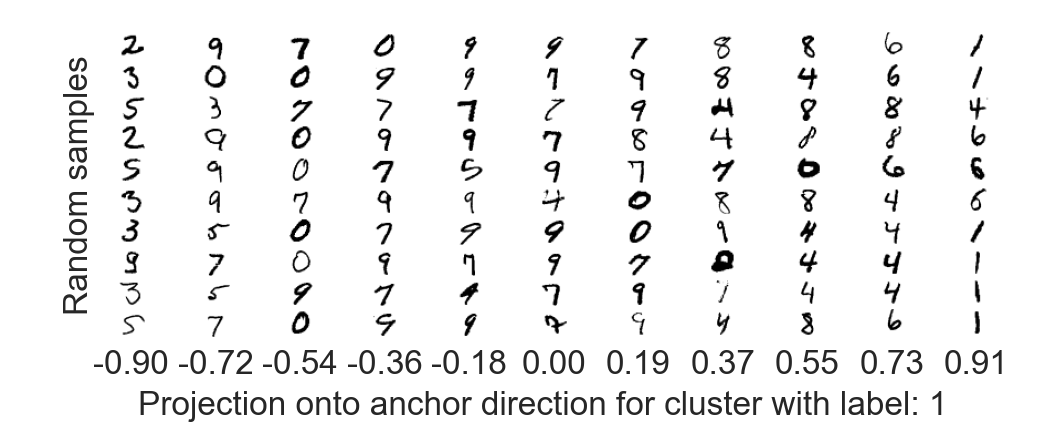

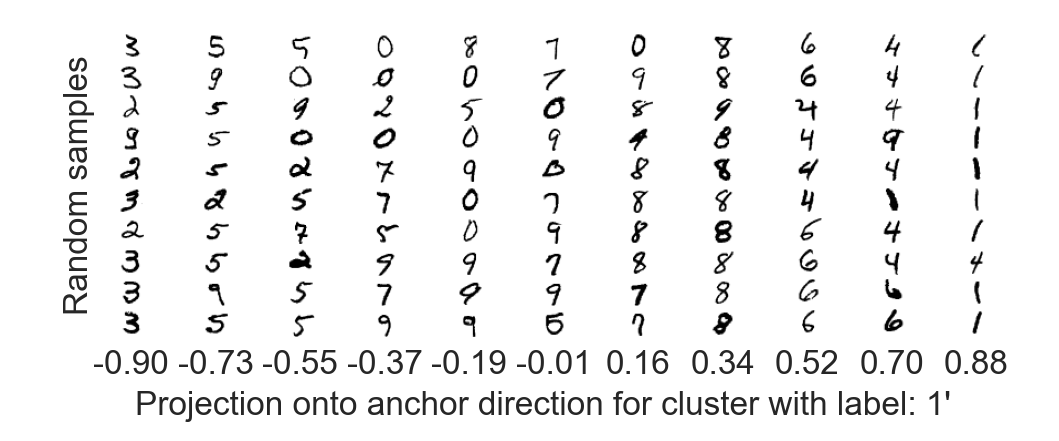

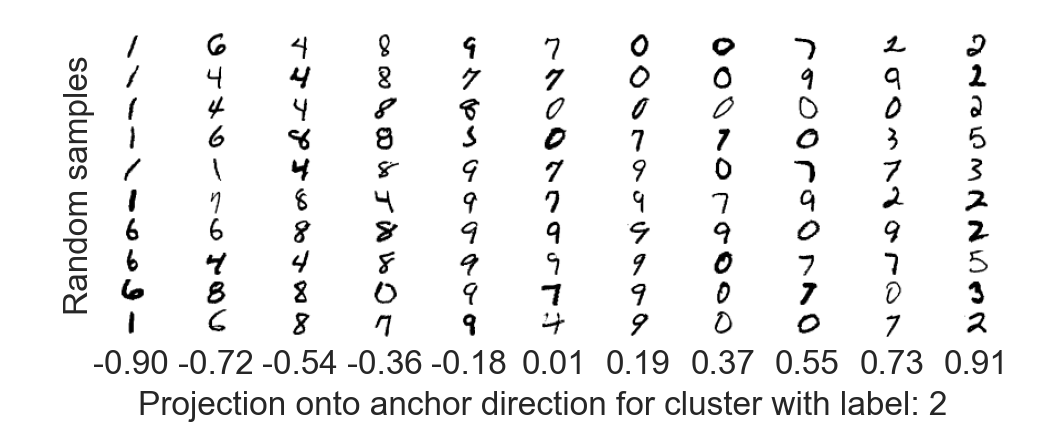

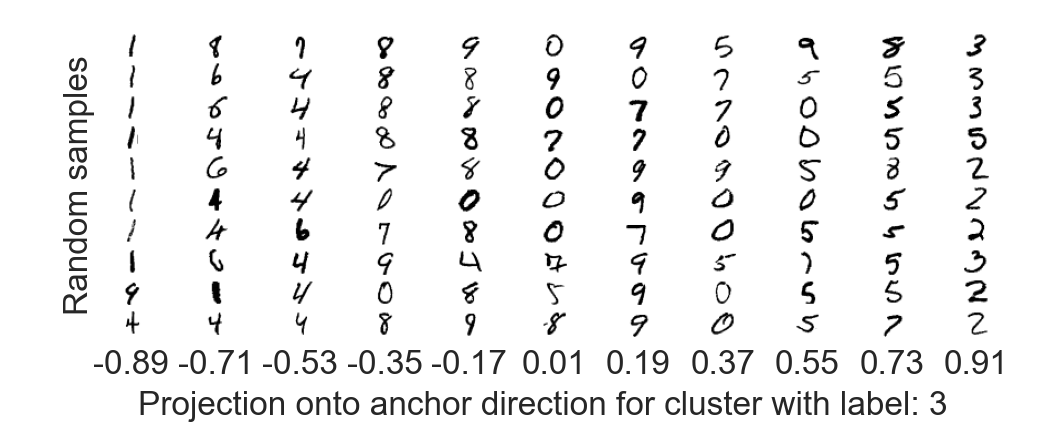

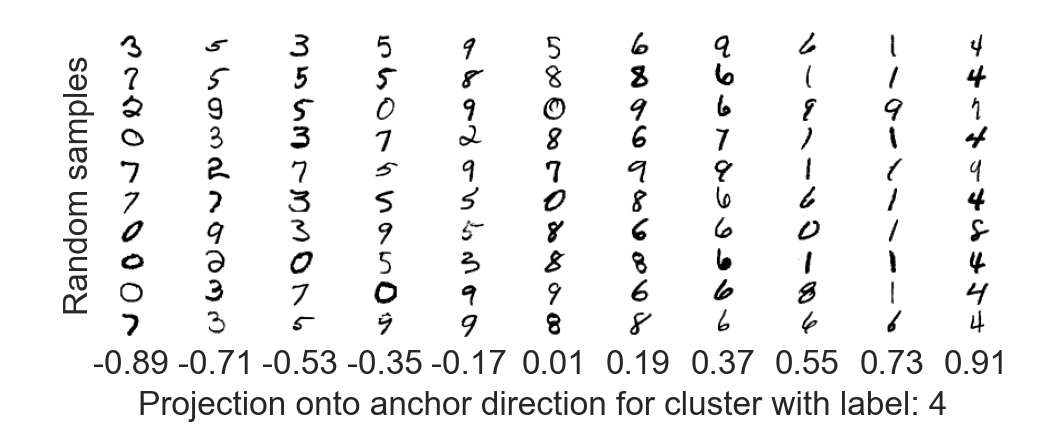

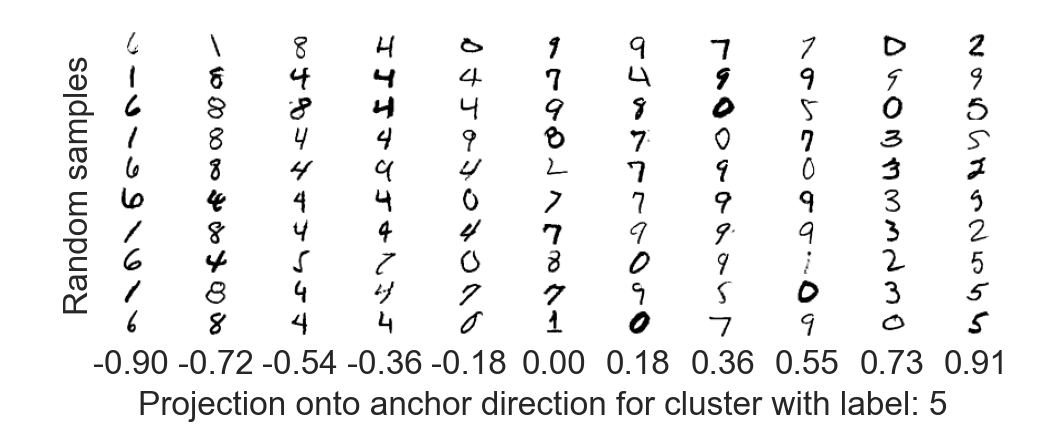

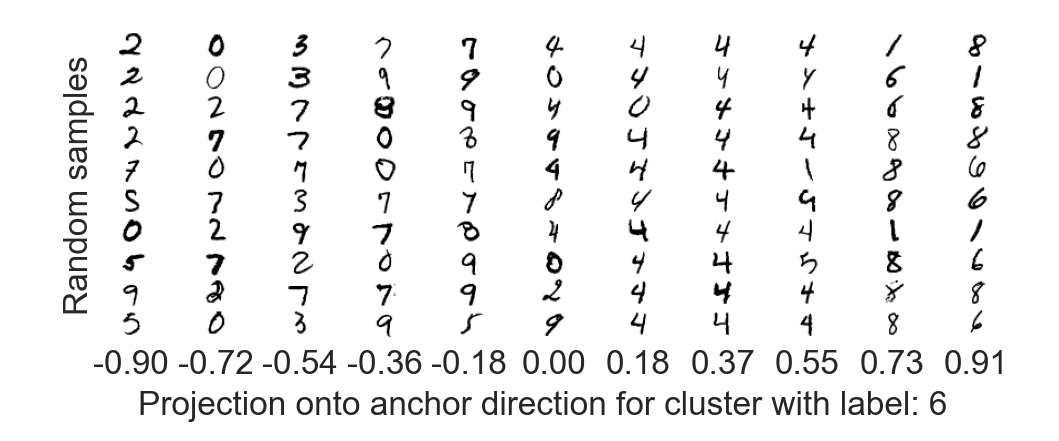

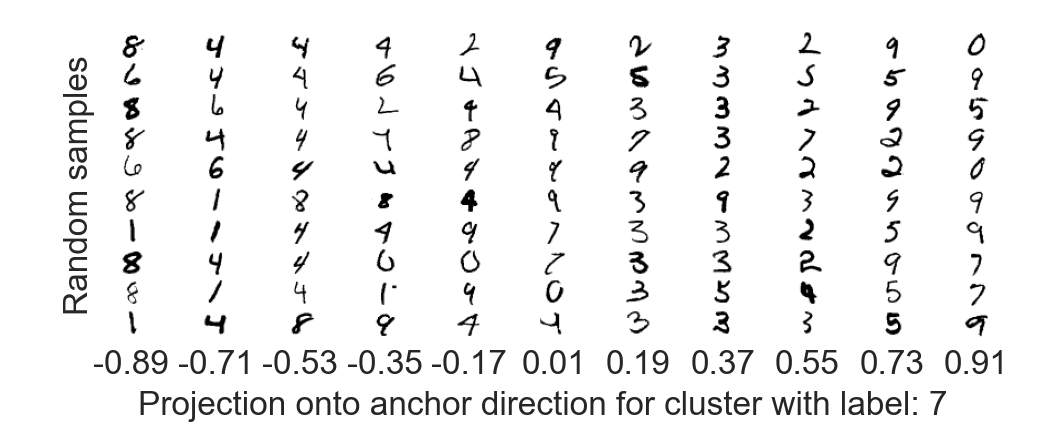

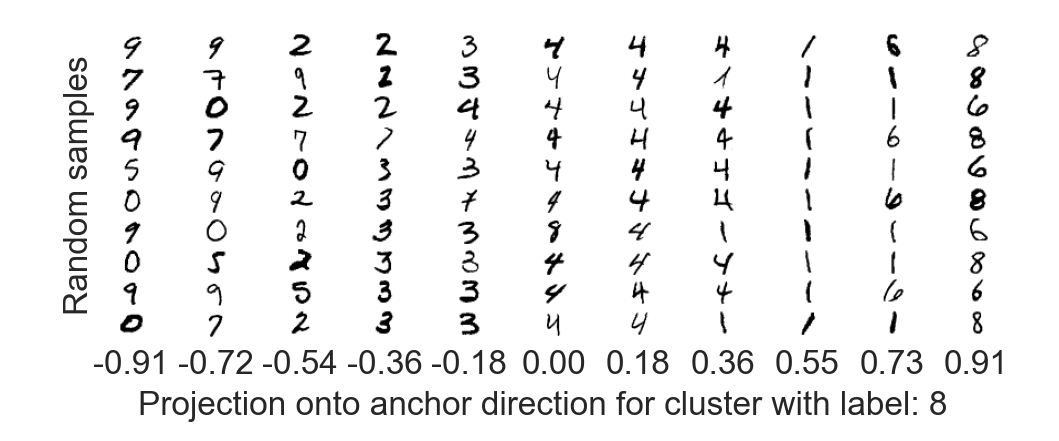

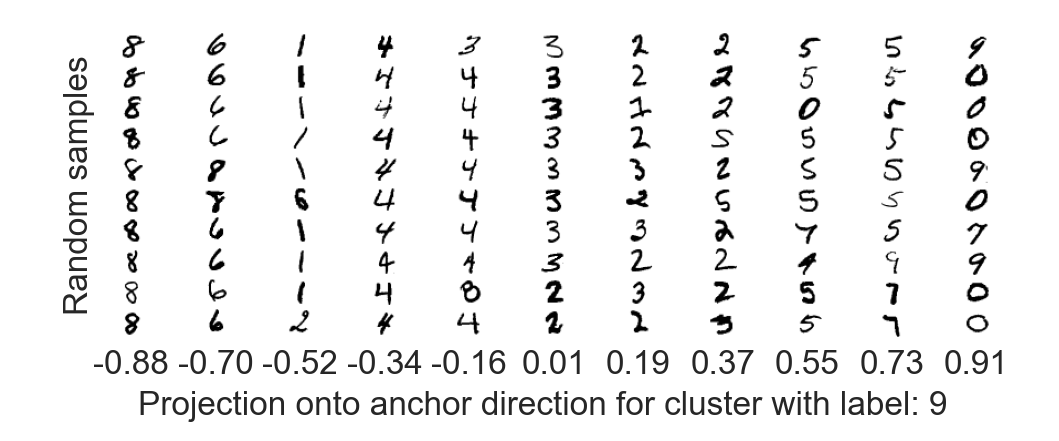

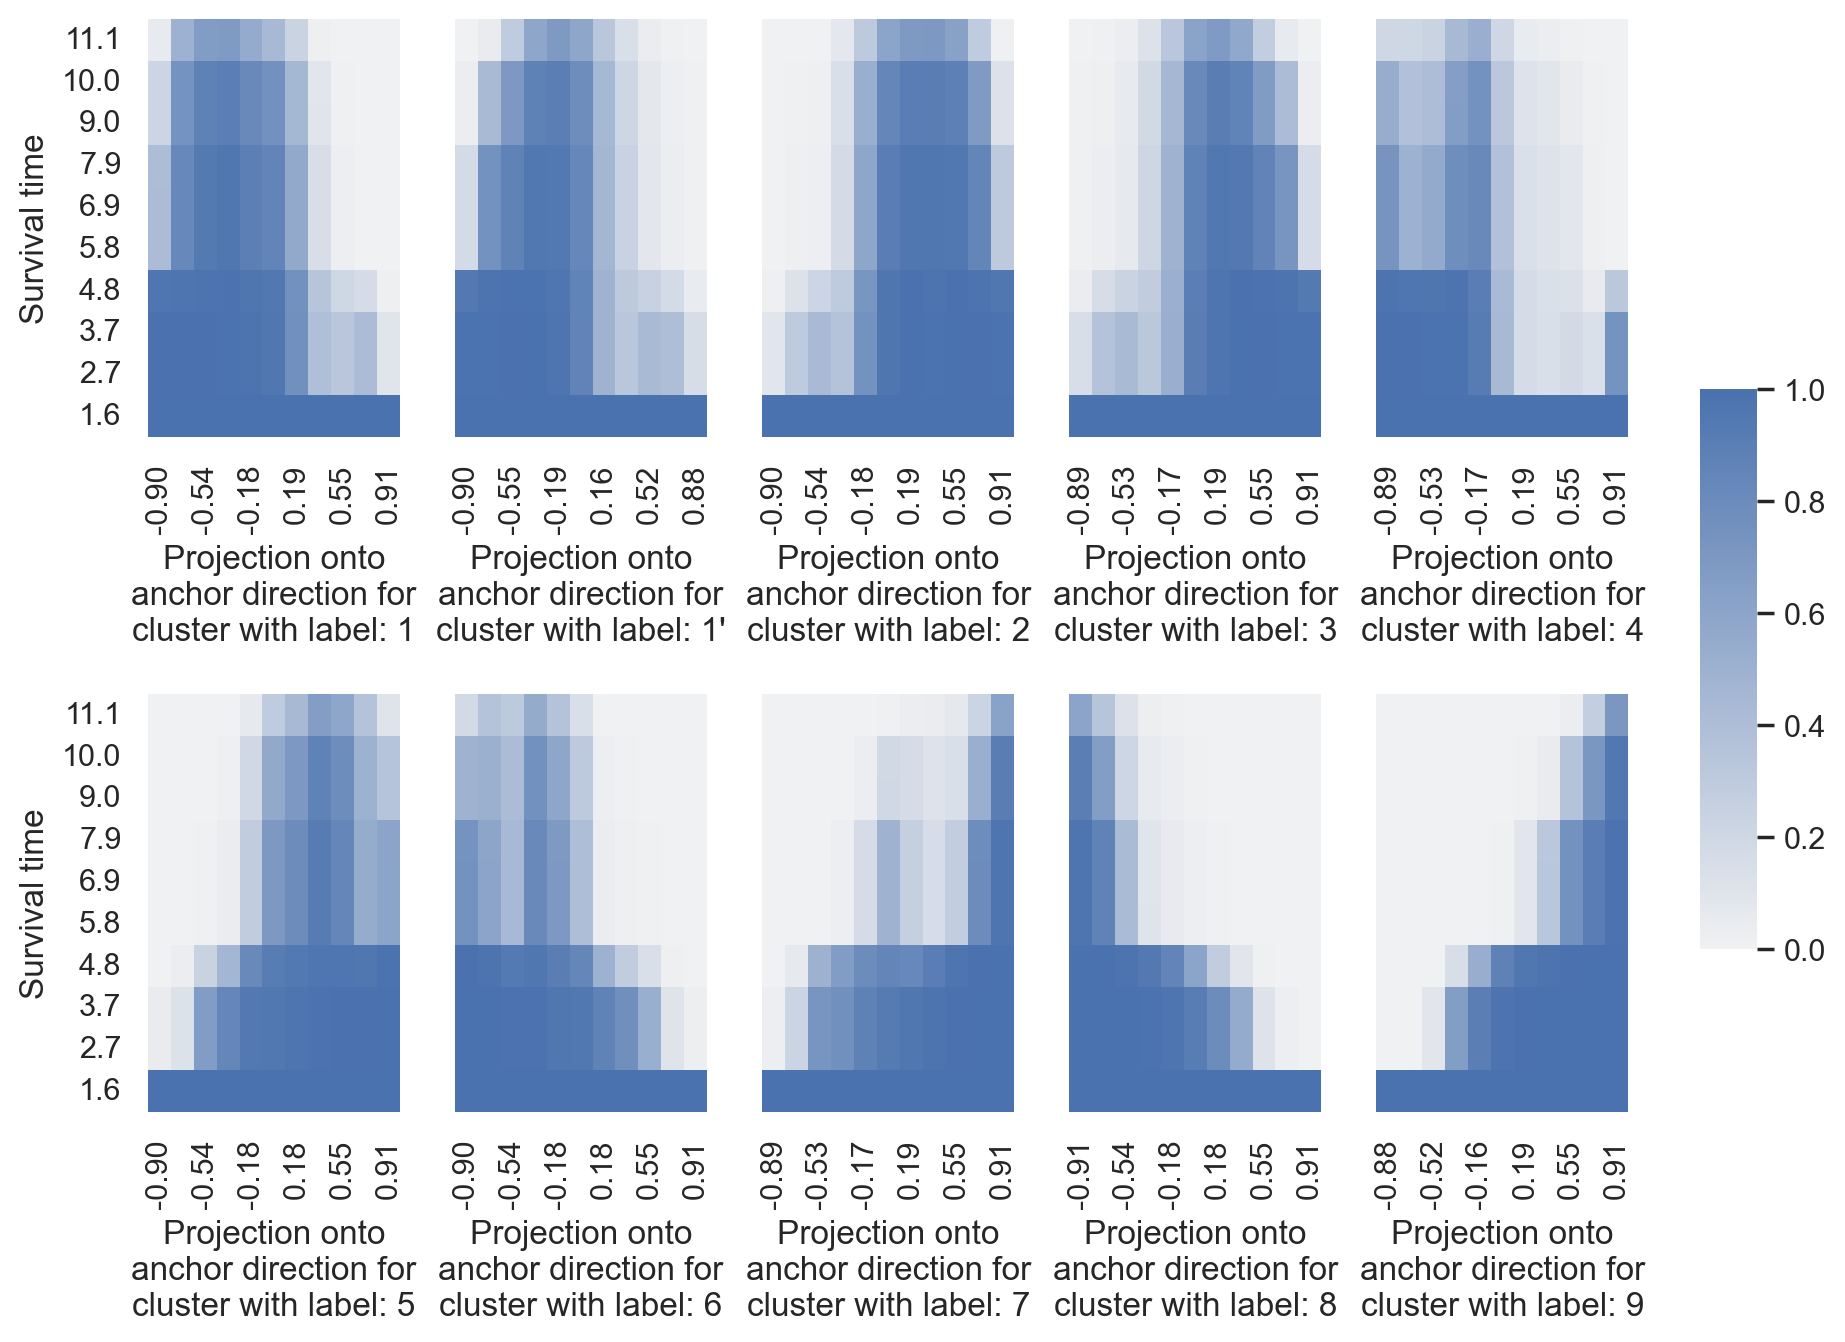

In [18]:
for final_n_clusters in [4, 8, 9, 10]:
    # figure out how to renumber the cluster labels to best match the digits using the ground truth digit
    # anchor directions
    final_cluster_assignment = cluster_assignments[n_clusters_to_try.index(final_n_clusters)]
    anchor_directions = np.array([emb_direction[final_cluster_assignment == cluster_idx].mean(axis=0) - center_of_mass
                                  for cluster_idx in range(final_n_clusters)])
    anchor_directions_normalized = l2_normalize_rows(anchor_directions)

    # basic idea for finding the match for the j-th cluster: find whichever digit's anchor direction best aligns
    # with j-th cluster's anchor direction

    already_matched = {}
    new_cluster_labels = []
    for cluster_idx in range(final_n_clusters):
        # find digit with anchor direction that best matches the current cluster's anchor direction
        match_digit = \
            np.argmax([np.dot(digit_anchor_directions_normalized[idx2],
                              anchor_directions_normalized[cluster_idx])
                       for idx2 in range(10)])

        # note that `suffix` and `new_cluster_labels` are just for text annotation
        # (in case a digit is matched to twice, we add a prime symbol to the second match so that,
        # for example, if digit 1 gets matched a second time, it will display as "1'")
        suffix = ''
        if match_digit not in already_matched:
            already_matched[match_digit] = [cluster_idx]
        else:
            suffix += "'" * len(already_matched[match_digit])
            already_matched[match_digit].append(cluster_idx)
        new_cluster_labels.append('%d%s' % (match_digit, suffix))

    new_cluster_label_ordering = []
    for digit in range(10):
        if digit in already_matched:
            for cluster_idx in already_matched[digit]:
                new_cluster_label_ordering.append(cluster_idx)
    new_cluster_label_ordering = np.array(new_cluster_label_ordering)

    heatmap = np.zeros((10, final_n_clusters))
    for digit in range(10):
        for new_cluster_idx in range(final_n_clusters):
            mask = (digit_vis == digit)
            projections = np.dot(l2_normalize_rows(emb_vis[mask] - center_of_mass),
                                 anchor_directions_normalized[
                                     new_cluster_label_ordering[new_cluster_idx]])
            heatmap[digit, new_cluster_idx] = projections.mean()

    plt.figure(figsize=(4.5, 4))
    ax = sns.heatmap(pd.DataFrame(heatmap,
                                  index=['%d' % idx for idx in range(10)],
                                  columns=['%s' % new_cluster_labels[
                                                      new_cluster_label_ordering[new_cluster_idx]]
                                           for new_cluster_idx in range(final_n_clusters)]),
                     cmap=sns.blend_palette(['#e97b8c', '#ffffff', '#4a72ae'], as_cmap=True))
    plt.xlabel('Clusters from %d-component mixture of von Mises-Fisher distributions\n(each cluster label is the digit the cluster matches best with)'
               % final_n_clusters)
    plt.ylabel('True digit label')
    plt.savefig('survival-mnist-nclusters%d-cluster-vs-digit-average-projection-heatmap-with-relabeling-hypersphere.pdf'
                % final_n_clusters, bbox_inches='tight')

    n_bins = 11
    for new_cluster_idx in range(final_n_clusters):
        old_cluster_idx = new_cluster_label_ordering[new_cluster_idx]
        cluster_label = new_cluster_labels[old_cluster_idx]

        projections = np.dot(emb_vis_normalized, anchor_directions_normalized[old_cluster_idx])
        hist, bin_edges = np.histogram(projections, bins=n_bins,
                                       range=(projections.min(), projections.max()))
        bin_assignments = np.digitize(projections, bin_edges) - 1
        bin_assignments[bin_assignments == bin_assignments.max()] -= 1

        n_samples_per_bin = 10
        rng = np.random.default_rng(632144477)
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                                 figsize=(6, 2))
        for idx in range(n_bins):
            mask = (bin_assignments == idx)
            sample_indices = rng.permutation(mask.sum())[:n_samples_per_bin]
            sample_images = np.where(mask)[0][sample_indices]
            print(idx, ':', sample_images)
            offset = n_samples_per_bin - len(sample_images)
            for row_idx, image_idx in enumerate(sample_images):
                plt.subplot(n_samples_per_bin, n_bins, (row_idx + offset) * n_bins + idx + 1)
                plt.imshow(raw_vis[image_idx][0], cmap='binary')
                plt.tick_params(
                    axis='both',
                    which='both',
                    bottom=False,
                    top=False,
                    labelbottom=False,
                    labelleft=False)
                plt.grid(False)
                if row_idx + offset == n_samples_per_bin - 1:  # last row
                    plt.xlabel('%.02f' % (bin_edges[idx:idx+2].sum()/2))
        plt.subplots_adjust(wspace=0, hspace=0)
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', which='both', top=False,
                        bottom=False, left=False, right=False)
        plt.grid(b=None)
        plt.ylabel('Random samples', labelpad=-27)
        plt.xlabel('Projection onto anchor direction for cluster with label: %s'
                   % cluster_label,
                   labelpad=-1,
                   horizontalalignment='center', x=.488)
        plt.savefig('survival-mnist-nclusters%d-anchor%d-hypersphere.pdf' % (final_n_clusters, new_cluster_idx + 1),
                    bbox_inches='tight', dpi=300)

    # compute survival probability heatmaps
    n_rows = 10
    discrete_time_grid = np.linspace(unique_train_times.min(), unique_train_times.max(), n_rows)

    all_survival_probability_heatmaps = []
    all_bin_edges = []
    for new_cluster_idx in range(final_n_clusters):
        old_cluster_idx = new_cluster_label_ordering[new_cluster_idx]
        cluster_label = new_cluster_labels[old_cluster_idx]

        projections = np.dot(emb_vis_normalized, anchor_directions_normalized[old_cluster_idx])

        bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
        bin_edges_copy_with_inf_right_edge = bin_edges.copy()
        bin_edges_copy_with_inf_right_edge[-1] = np.inf

        bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

        heatmap = np.zeros((n_rows, n_bins))
        for projection_bin_idx in range(n_bins):
            projection_bin_surv = interpolate.interp1d(
                unique_train_times,
                predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
            heatmap[:, projection_bin_idx] = projection_bin_surv(discrete_time_grid)[::-1]

        all_survival_probability_heatmaps.append(heatmap)
        all_bin_edges.append(bin_edges)

    if final_n_clusters == 4:
        fig, axn = plt.subplots(1, 4, sharex=False, sharey=True, figsize=(9.5, 3.5))
    elif final_n_clusters == 8:
        fig, axn = plt.subplots(2, 4, sharex=False, sharey=True, figsize=(9.5, 7))
    elif final_n_clusters == 9:
        fig, axn = plt.subplots(3, 3, sharex=False, sharey=True, figsize=(7.125, 10.5))
    elif final_n_clusters == 10:
        fig, axn = plt.subplots(2, 5, sharex=False, sharey=True, figsize=(9.5, 7))
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for new_cluster_idx in range(final_n_clusters):
        old_cluster_idx = new_cluster_label_ordering[new_cluster_idx]
        cluster_label = new_cluster_labels[old_cluster_idx]
        ax = axn.flat[new_cluster_idx]
        sns.heatmap(
            pd.DataFrame(all_survival_probability_heatmaps[new_cluster_idx],
                         index=['%.1f' % x for x in discrete_time_grid[::-1]],
                         columns=['%.2f' % x for x in (all_bin_edges[new_cluster_idx][:-1]
                                                       + all_bin_edges[new_cluster_idx][1:])/2]),
            cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
            vmin=0, vmax=1, ax=ax,
            cbar=(new_cluster_idx == 0),
            cbar_ax=None if (new_cluster_idx != 0) else cbar_ax)
        ax.set_xlabel('Projection onto\nanchor direction for\ncluster with label: %s'
                      % cluster_label)
        if final_n_clusters == 8:
            if new_cluster_idx % 4 == 0:
                ax.set_ylabel('Survival time')
        elif final_n_clusters == 9:
            if new_cluster_idx % 3 == 0:
                ax.set_ylabel('Survival time')
        elif final_n_clusters == 10:
            if new_cluster_idx % 5 == 0:
                ax.set_ylabel('Survival time')
        elif new_cluster_idx == 0:
            ax.set_ylabel('Survival time')
    fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)
    plt.savefig('survival-mnist-nclusters%d-surv-prob-heatmaps-hypersphere.pdf' % final_n_clusters,
                bbox_inches='tight')

### Anchor directions based on using each digit as a concept

0 : [3730 4285 3636 2304 5035 3080  283 6547 2287 2346]
1 : [7301 3426 3570 2220 4307 1577 3242 7352 2979 4193]
2 : [ 824 6634  832 3521 4492 1260 6009 4881 4095 4447]
3 : [3245 4038 5486 3967 4210  528 1682 1504 3612 2268]
4 : [2154 4368   47 2256  140 1747 6445 3314 4356 5210]
5 : [ 124 2153 1811 6335  462 5943 6982 6045 6756 5526]
6 : [4853  966 2621 1724 2634 1139 3022 2281 2477  158]
7 : [ 169 1455 6267 5150 1996 5507 6845 2983 6216 6342]
8 : [1086 4088 4489 4508 3863 2606 1266 2786 7463 5411]
9 : [3705 6048  488 5959 1764 3546 4500  683 1758 2200]
10 : [7072 3895 4536 2778 5515  904 1448 1625 5570 4845]


/tmp/ipykernel_4001613/3847893054.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


0 : [7371 1644 5284 5488 1585 1734 4240 2137 7049  448]
1 : [6570 2566 1500 5796   25 4643 4016 1759  648 5885]
2 : [7495 3474 3319 7109 1590 5443 3449 3053 5936  745]
3 : [ 584 3314 4049 4360 4917 4477 7307 5838 3741 2679]
4 : [ 398 4496 6619 3489 1266  790 1663 3923 1931 6393]
5 : [2806 3026 2786 6620  147    5 5332 6144 4065  361]
6 : [ 794 6427  896 4994 2628 1547 2002 1552 5578 7443]
7 : [3665  347 4356 2836 6366 1621 7481 4740   95 1767]
8 : [1136 4122 1344 4069 7298 4274 2428 5779 1110 1162]
9 : [ 362  939 3982 3976 1848 5510 3873 3560 5646 2304]
10 : [6659 5837 1540 6946 1469 7000 5393 6054 1888 2499]
0 : [1664 3825 1510 6062 1333 4525 6767 2698 5067 3498]
1 : [5363 4859 4320 1323 6666 2336 1388   98 2735 2452]
2 : [6111 5528 6662 5538 3056 2946 5223  172 6256 3976]
3 : [2450 1189 7153 6553  265 3979 2628 1262 3132  347]
4 : [7187  751  365 4482 3066 2720 3048 5255 5545 6511]
5 : [ 585 5020 4088  919 6393 3506 4549 3600 2080 1488]
6 : [2059  123  449 5495 1881  797  607 7278 37

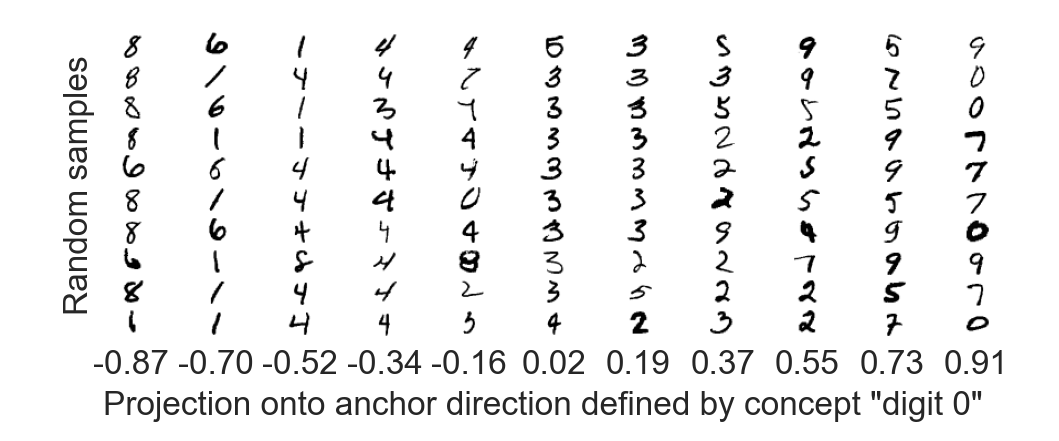

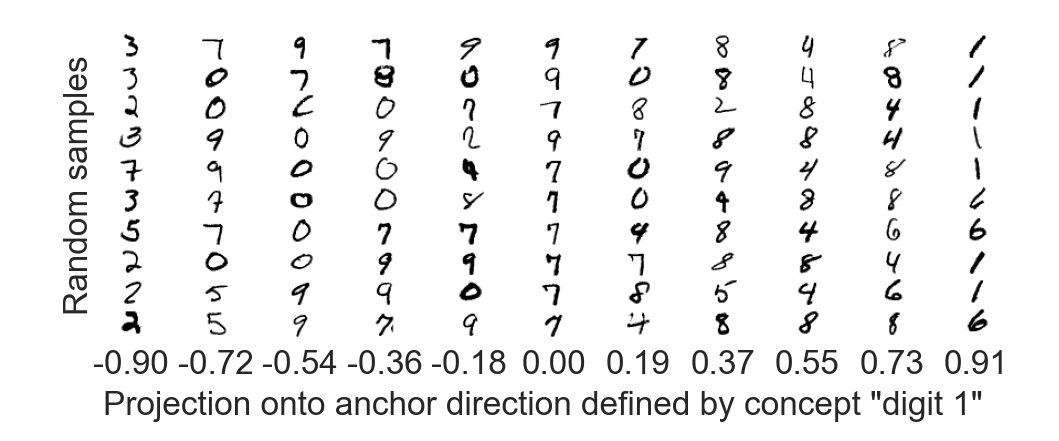

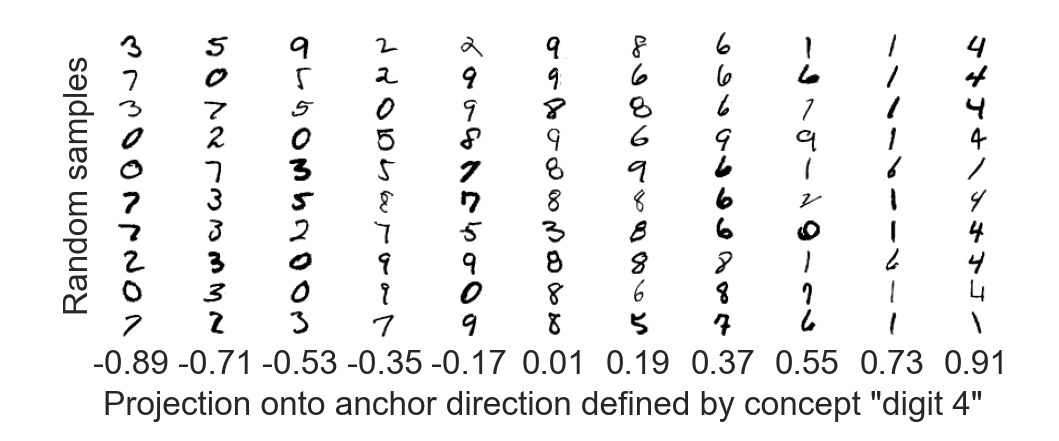

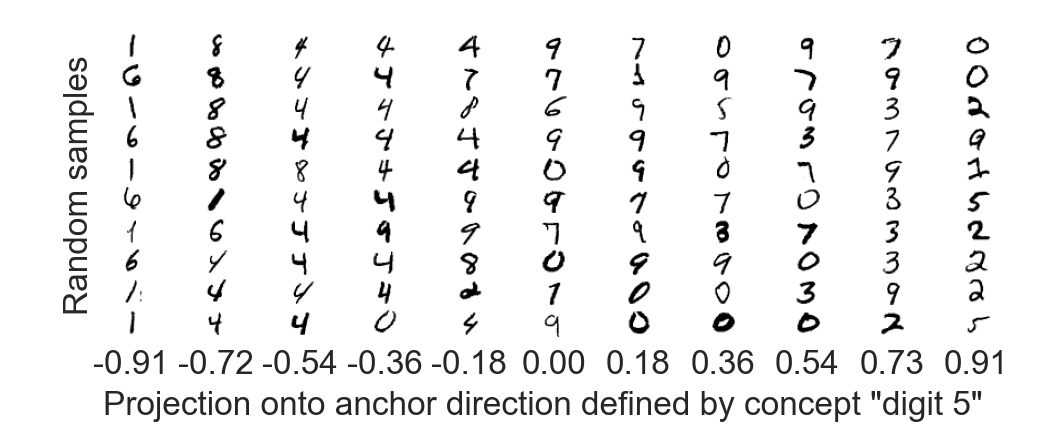

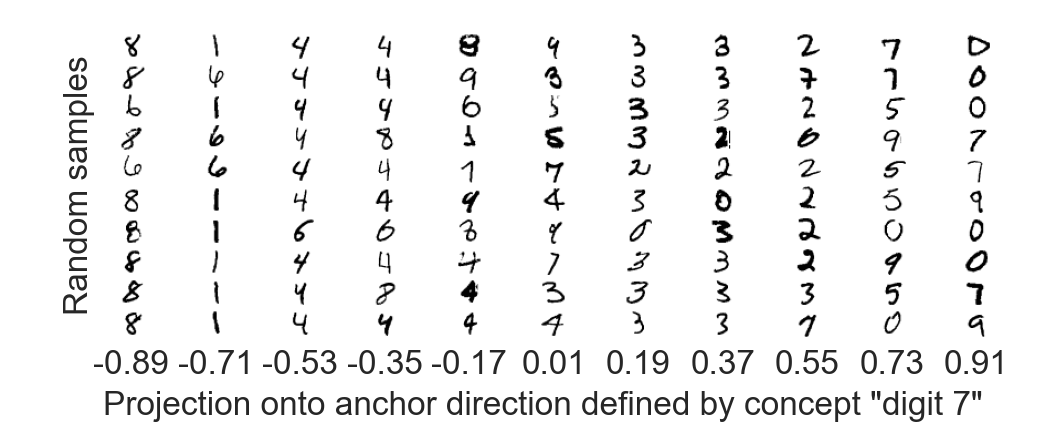

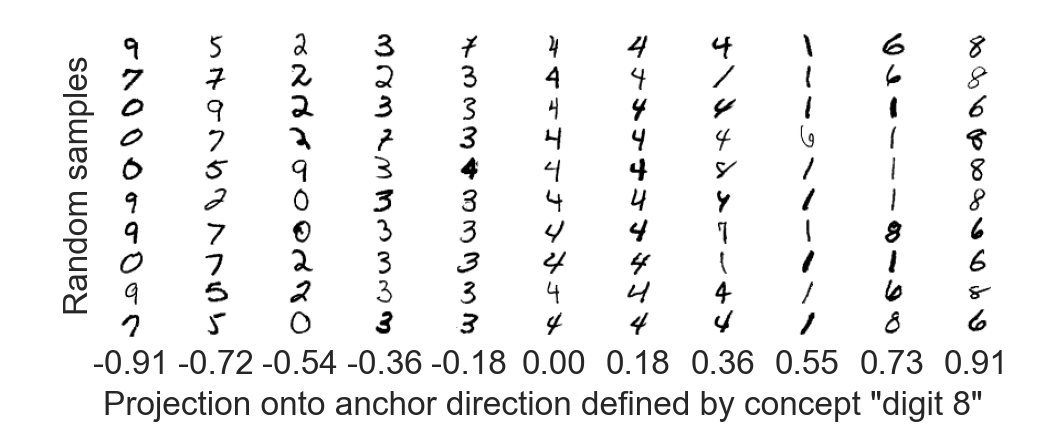

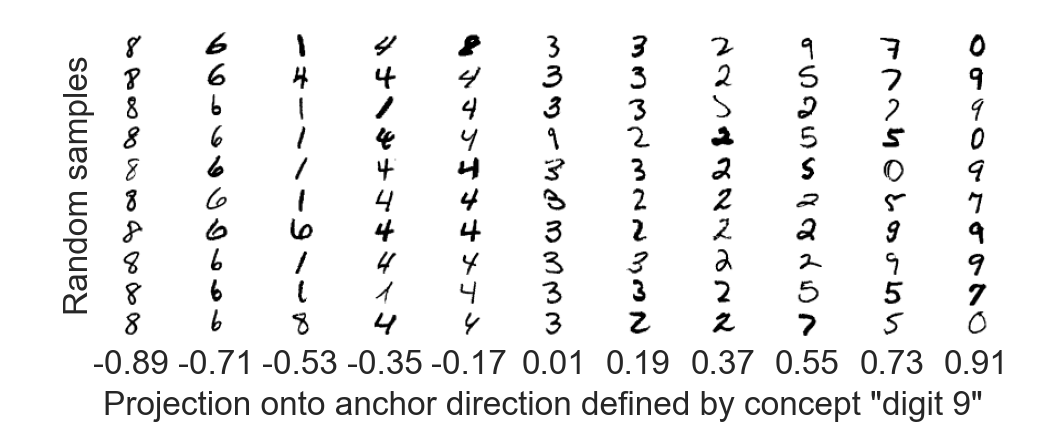

In [19]:
n_bins = 11
for digit in range(10):
    projections = np.dot(emb_vis_normalized, digit_anchor_directions_normalized[digit])
    hist, bin_edges = np.histogram(projections, bins=n_bins,
                                   range=(projections.min(), projections.max()))
    bin_assignments = np.digitize(projections, bin_edges) - 1
    bin_assignments[bin_assignments == bin_assignments.max()] -= 1

    n_samples_per_bin = 10
    rng = np.random.default_rng(632144477)
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                             figsize=(6, 2))
    for idx in range(n_bins):
        mask = (bin_assignments == idx)
        sample_indices = rng.permutation(mask.sum())[:n_samples_per_bin]
        sample_images = np.where(mask)[0][sample_indices]
        print(idx, ':', sample_images)
        offset = n_samples_per_bin - len(sample_images)
        for row_idx, image_idx in enumerate(sample_images):
            plt.subplot(n_samples_per_bin, n_bins, (row_idx + offset) * n_bins + idx + 1)
            plt.imshow(raw_vis[image_idx][0], cmap='binary')
            plt.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False,
                labelbottom=False,
                labelleft=False)
            plt.grid(False)
            if row_idx + offset == n_samples_per_bin - 1:  # last row
                plt.xlabel('%.02f' % (bin_edges[idx:idx+2].sum()/2))
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False,
                    bottom=False, left=False, right=False)
    plt.grid(b=None)
    plt.ylabel('Random samples', labelpad=-27)
    plt.xlabel('Projection onto anchor direction defined by concept "digit %d"'
               % digit,
               labelpad=-1,
               horizontalalignment='center', x=.488)
    plt.savefig('survival-mnist-concept%d-hypersphere.pdf' % digit, bbox_inches='tight', dpi=300)

In [20]:
# compute survival probability heatmaps

n_rows = 10
discrete_time_grid = np.linspace(unique_train_times.min(), unique_train_times.max(), n_rows)

all_survival_probability_heatmaps = []
all_bin_edges = []
for digit in range(10):
    projections = np.dot(emb_vis_normalized, digit_anchor_directions_normalized[digit])

    bin_counts, bin_edges = np.histogram(projections, bins=n_bins)
    bin_edges_copy_with_inf_right_edge = bin_edges.copy()
    bin_edges_copy_with_inf_right_edge[-1] = np.inf

    bin_assignments = np.digitize(projections, bin_edges_copy_with_inf_right_edge) - 1

    heatmap = np.zeros((n_rows, n_bins))
    for projection_bin_idx in range(n_bins):
        projection_bin_surv = interpolate.interp1d(
            unique_train_times,
            predicted_surv_vis[bin_assignments == projection_bin_idx].mean(axis=0))
        heatmap[:, projection_bin_idx] = projection_bin_surv(discrete_time_grid)[::-1]

    all_survival_probability_heatmaps.append(heatmap)
    all_bin_edges.append(bin_edges)

/tmp/ipykernel_4001613/1329735236.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)


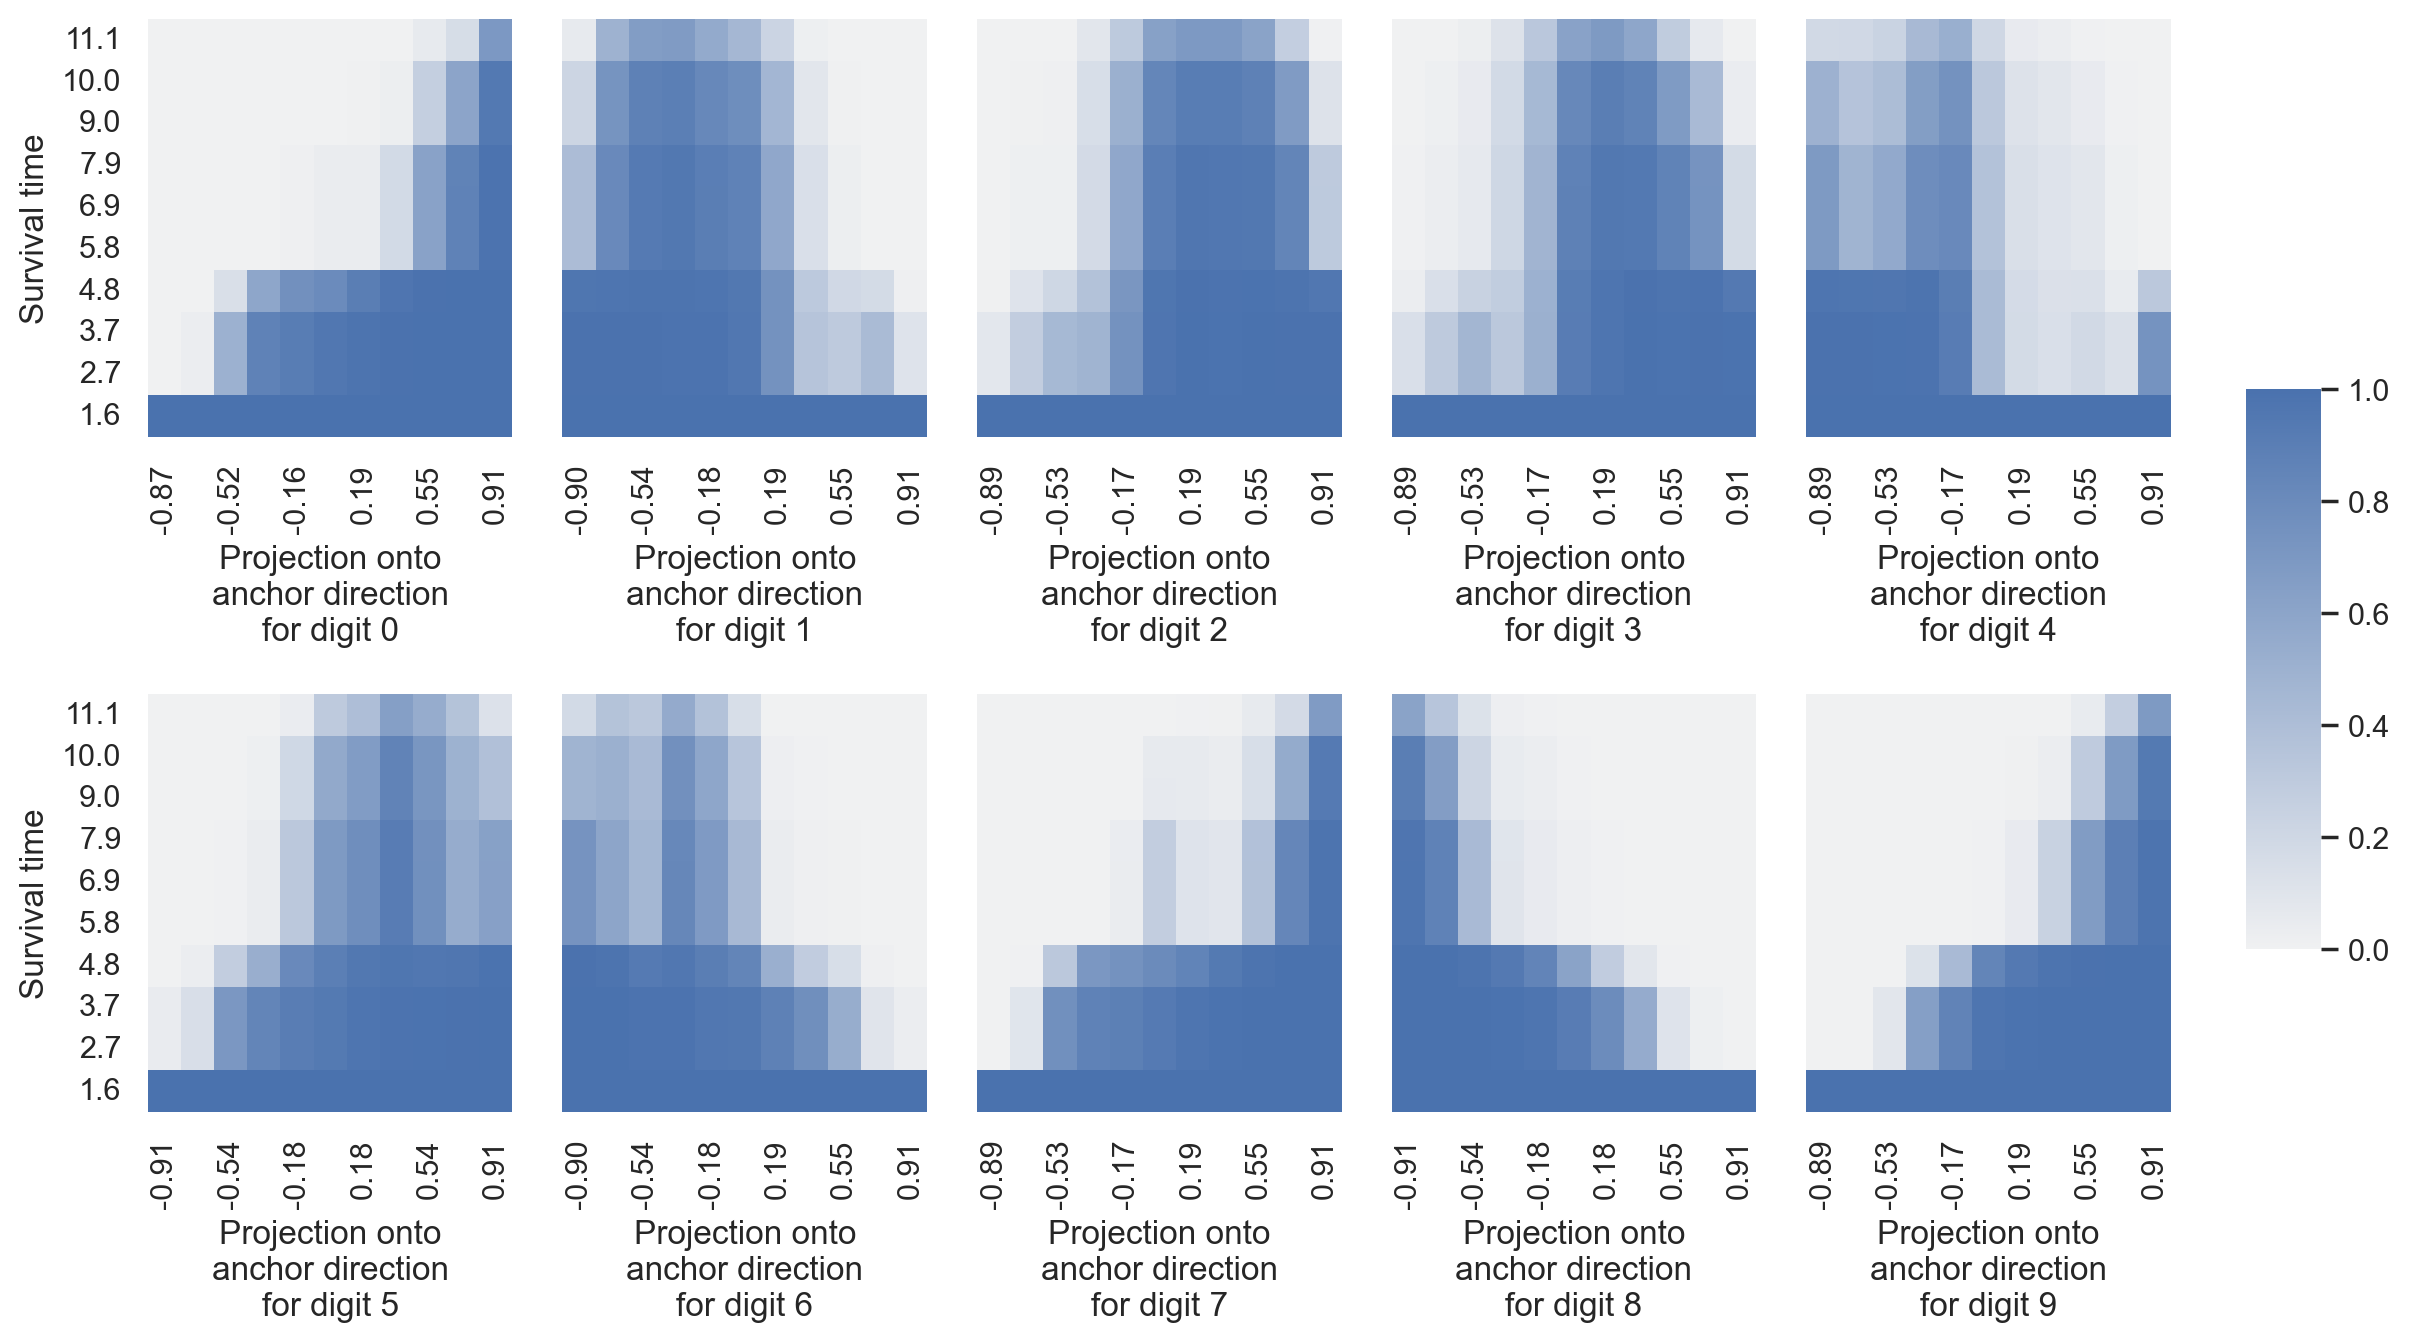

In [21]:
# plot all survival probability heatmaps

fig, axn = plt.subplots(2, 5, sharex=False, sharey=True, figsize=(12.5, 7))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for digit in range(10):
    ax = axn.flat[digit]
    sns.heatmap(
        pd.DataFrame(all_survival_probability_heatmaps[digit],
                     index=['%.1f' % x for x in discrete_time_grid[::-1]],
                     columns=['%.2f' % x for x in (all_bin_edges[digit][:-1]
                                                   + all_bin_edges[digit][1:])/2]),
        cmap=sns.light_palette("#4a72ae", reverse=False, as_cmap=True),
        vmin=0, vmax=1, ax=ax,
        cbar=(digit == 0),
        cbar_ax=None if (digit != 0) else cbar_ax)
    ax.set_xlabel('Projection onto\nanchor direction\nfor digit %d' % digit)
    if digit % 5 == 0:
        # ax.set_yticklabels(list(df.index), rotation=0)
        ax.set_ylabel('Survival time')
fig.tight_layout(rect=[0, 0, .9, 1], pad=1.5)
plt.savefig('survival-mnist-digit-concepts-surv-prob-heatmaps-hypersphere.pdf', bbox_inches='tight')

### Anchor direction based on using "censored" as a concept

0 : [3980 4694 2625 5768 3296 6336 2953 6418  302  422]
1 : [6294  315 3379 6776 7304 4855 6611 7012 5148 6814]
2 : [ 534  172 2672  287 2925 3437 4942 6160 6480 2110]
3 : [1501   13 2539 5765 2750    4 5267 5682 6445 4533]
4 : [5976 1135 2256 6568 7242 3245 4463 6666 4246 3612]
5 : [4004  733 6407 6237 6553 6175  750 2820 2407 7423]
6 : [7198 4763 2004  102 4288 5415 6825 2541 4178 2887]
7 : [2285 4199 5009  536 4363 1439 7429 7480 4814 6269]
8 : [1937 1754 6323 3711 6414 3108  483 7312 4309  272]
9 : [4214 1058 1963 6981 1266  924 2648 1777 3312 3518]
10 : [ 307 5493 5944 2688 3529 4690 3119 2203 4543 5873]


/tmp/ipykernel_4001613/3502610094.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


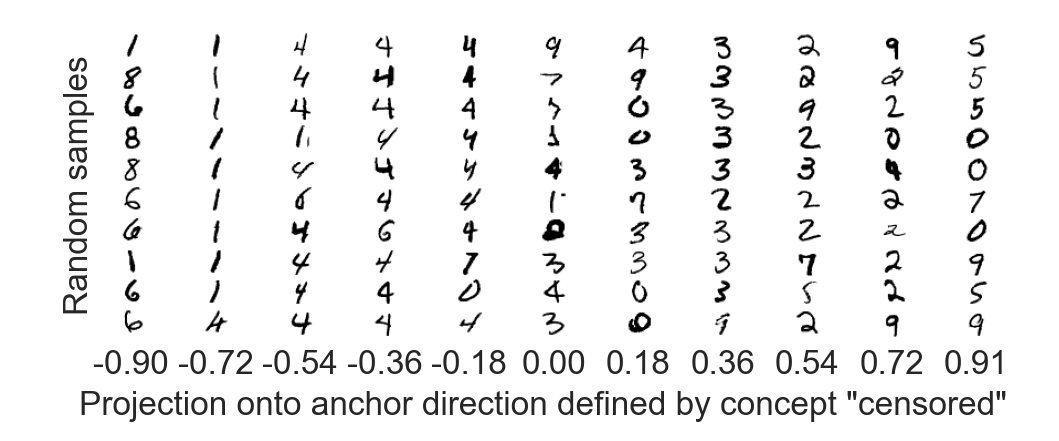

In [22]:
anchor_direction = emb_direction[label_direction[:, 1] == 0].mean(axis=0) - center_of_mass
anchor_direction /= np.linalg.norm(anchor_direction)

emb_vis_normalized = l2_normalize_rows(emb_vis - center_of_mass)

n_bins = 11
projections = np.dot(emb_vis_normalized, anchor_direction)
hist, bin_edges = np.histogram(projections, bins=n_bins,
                               range=(projections.min(), projections.max()))
bin_assignments = np.digitize(projections, bin_edges) - 1
bin_assignments[bin_assignments == bin_assignments.max()] -= 1

n_samples_per_bin = 10
rng = np.random.default_rng(632144477)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True,
                         figsize=(6, 2))
for idx in range(n_bins):
    mask = (bin_assignments == idx)
    sample_indices = rng.permutation(mask.sum())[:n_samples_per_bin]
    sample_images = np.where(mask)[0][sample_indices]
    print(idx, ':', sample_images)
    offset = n_samples_per_bin - len(sample_images)
    for row_idx, image_idx in enumerate(sample_images):
        plt.subplot(n_samples_per_bin, n_bins, (row_idx + offset) * n_bins + idx + 1)
        plt.imshow(raw_vis[image_idx][0], cmap='binary')
        plt.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            labelbottom=False,
            labelleft=False)
        plt.grid(False)
        if row_idx + offset == n_samples_per_bin - 1:  # last row
            plt.xlabel('%.02f' % (bin_edges[idx:idx+2].sum()/2))
plt.subplots_adjust(wspace=0, hspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False,
                bottom=False, left=False, right=False)
plt.grid(b=None)
plt.ylabel('Random samples', labelpad=-27)
plt.xlabel('Projection onto anchor direction defined by concept "censored"',
           labelpad=-1,
           horizontalalignment='center', x=.488)
plt.savefig('survival-mnist-censored-hypersphere.pdf', bbox_inches='tight', dpi=300)